<a href="https://colab.research.google.com/github/cty20010831/SOCI-40133-Computational-Content-Analysis/blob/main/week%204/4_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

Also note that the code in this Notebook can take many minutes or even hours to run. This is the case for most NLP research these days, and it's a good opportunity to start thinking about how to manage high-compute workloads, such as running code on small samples to test it, loading datafiles in [chunks](https://stackoverflow.com/a/25962187), or [multiprocessing](https://en.wikipedia.org/wiki/Multiprocessing).

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?***
For now, I have three research questions in mind regarding the influence of funding on psychology research:

1. How funding influence psychologist' research output (in terms of number of citations)?
2. Is there a "trap" of funding in which psychology researchers with funding are increasingly loosing the diversity of the resarch topics they examine?
3. What are the variation of the content/research topics of funded pscyhology papers (e.g., in terms of cross-disciplinary collaboration) for different types of funding types/categories?

## ***Why?***
The reason why I want to answer these research questions is that I am interested in the effects (and also, perhaps, meaningfulness) of funding in psychology papers. For instance, will the funding leads to more impactful and flourishing research? I think one implication here is that funding agencies can better decide upon what types of research projects (and researchers) they should grant funding on.

Another reason is that I am interested in the trend of psychology research over the past 20 years. Since we can extract the key psycholigical concepts (or topics) studied from the papers' abstract, we can capture how psycholigical concepts change in terms of frequency and diversity over time. For instance, on e hypothesis could be that there are increasing usage of quantitative/computational methods in the field of psychology.

## ***How?***
The first thing I am going to do is

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***
<300 words

In [ ]:
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [3]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [17]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath, encoding="ISO-8859-1") as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pd.DataFrame(senDict)

In [4]:
# Here I mount google drive. I stored all the data in the drive so I can extract data file directly from there. If you don't want to use the drive,
# you can always upload the data to /content/ directly.
# We recommend drive for the larger datasets.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/MACS_60000_Computational Content Analysis')

Now we can use the function in all the directories in `data/grimmerPressReleases`. If you are on Google Colab, note that rather than downloading GitHub data to your local machine and then uploading it to Drive, you can more quickly `git clone` directly to Colab, such as `!git clone https://github.com/lintool/GrimmerSenatePressReleases.git /drive/MyDrive/`, which then makes your `dataDir = 'drive/MyDrive/grimmerPressReleases/raw'`.

In [11]:
!git clone https://github.com/lintool/GrimmerSenatePressReleases.git

Cloning into 'GrimmerSenatePressReleases'...
remote: Enumerating objects: 72693, done.
remote: Total 72693 (delta 0), reused 0 (delta 0), pack-reused 72693
Receiving objects: 100% (72693/72693), 95.17 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (2642/2642), done.
Updating files: 100% (72788/72788), done.


In [18]:
dataDir = 'GrimmerSenatePressReleases/raw'

senReleasesDF = pd.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Akaka,GrimmerSenatePressReleases/raw/Akaka/10Apr2007...,"April06,200712:44 AM EDTAP Newsmaker: Akaka se..."
10,Akaka,GrimmerSenatePressReleases/raw/Akaka/10May2007...,WASHINGTON - U.S. Senators Daniel K. Inouye an...
20,Akaka,GrimmerSenatePressReleases/raw/Akaka/11Jan2007...,"Washington, D.C. - U.S. Senators Daniel K. Aka..."
30,Akaka,GrimmerSenatePressReleases/raw/Akaka/12Apr2005...,"Washington, D.C. - U.S. Senator Daniel K. Akak..."
40,Akaka,GrimmerSenatePressReleases/raw/Akaka/12Jul2006...,"Washington, D.C. - Senator Daniel K. Akaka (D-..."
50,Akaka,GrimmerSenatePressReleases/raw/Akaka/13Feb2006...,"Washington, D.C. -- Today the American Bar Ass..."
60,Akaka,GrimmerSenatePressReleases/raw/Akaka/13Mar2006...,"Washington, D.C. - Senator Daniel K. Akaka mad..."
70,Akaka,GrimmerSenatePressReleases/raw/Akaka/14Dec2007...,"Washington, DC - U.S. Senators Daniel K. Akaka..."
80,Akaka,GrimmerSenatePressReleases/raw/Akaka/14Nov2007...,"Washington, D.C. - U.S. Senator Daniel K. Akak..."
90,Akaka,GrimmerSenatePressReleases/raw/Akaka/15Feb2007...,"Washington, DC - U.S. Senator Daniel K. Akaka ..."


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [19]:
#Apply our functions, notice each row is a list of lists now
from tqdm import tqdm
tqdm.pandas()

senReleasesDF['tokenized_sents'] = senReleasesDF['text'].progress_apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
# With the latest spacy versions, you may get warnings with the following line of code. See the discussion here: https://github.com/allenai/allennlp/issues/5036
# senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

  0%|          | 0/72785 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 72785/72785 [3:42:41<00:00,  5.45it/s]


,category,filePath,text,tokenized_sents,normalized_sents
0,Akaka,GrimmerSenatePressReleases/raw/Akaka/10Apr2007...,"April06,200712:44 AM EDTAP Newsmaker: Akaka se...","[[April06,200712:44, AM, EDTAP, Newsmaker, Aka...","[[april06,200712:44, edtap, newsmaker, akaka, ..."
10,Akaka,GrimmerSenatePressReleases/raw/Akaka/10May2007...,WASHINGTON - U.S. Senators Daniel K. Inouye an...,"[[WASHINGTON, U.S., Senators, Daniel, K., Inou...","[[washington, u.s, senators, daniel, k., inouy..."
20,Akaka,GrimmerSenatePressReleases/raw/Akaka/11Jan2007...,"Washington, D.C. - U.S. Senators Daniel K. Aka...","[[Washington, D.C., U.S., Senators, Daniel, K....","[[washington, d.c, u.s, senators, daniel, k., ..."
30,Akaka,GrimmerSenatePressReleases/raw/Akaka/12Apr2005...,"Washington, D.C. - U.S. Senator Daniel K. Akak...","[[Washington, D.C., U.S., Senator, Daniel, K.,...","[[washington, d.c, u.s, senator, daniel, k., a..."
40,Akaka,GrimmerSenatePressReleases/raw/Akaka/12Jul2006...,"Washington, D.C. - Senator Daniel K. Akaka (D-...","[[Washington, D.C., Senator, Daniel, K., Akaka...","[[washington, d.c, senator, daniel, k., akaka,..."
50,Akaka,GrimmerSenatePressReleases/raw/Akaka/13Feb2006...,"Washington, D.C. -- Today the American Bar Ass...","[[Washington, D.C., Today, the, American, Bar,...","[[washington, d.c, today, american, bar, assoc..."
60,Akaka,GrimmerSenatePressReleases/raw/Akaka/13Mar2006...,"Washington, D.C. - Senator Daniel K. Akaka mad...","[[Washington, D.C., Senator, Daniel, K., Akaka...","[[washington, d.c, senator, daniel, k., akaka,..."
70,Akaka,GrimmerSenatePressReleases/raw/Akaka/14Dec2007...,"Washington, DC - U.S. Senators Daniel K. Akaka...","[[Washington, DC, U.S., Senators, Daniel, K., ...","[[washington, dc, u.s, senators, daniel, k., a..."
80,Akaka,GrimmerSenatePressReleases/raw/Akaka/14Nov2007...,"Washington, D.C. - U.S. Senator Daniel K. Akak...","[[Washington, D.C., U.S., Senator, Daniel, K.,...","[[washington, d.c, u.s, senator, daniel, k., a..."
90,Akaka,GrimmerSenatePressReleases/raw/Akaka/15Feb2007...,"Washington, DC - U.S. Senator Daniel K. Akaka ...","[[Washington, DC, U.S., Senator, Daniel, K., A...","[[washington, dc, u.s, senator, daniel, k., ak..."


In [6]:
# Save the normalized dataframe (to easily load it in Google Colab next time)
# senReleasesDF.to_json('senReleasesDF.json', orient='records', lines=True)
senReleasesDF = pd.read_json('senReleasesDF.json', orient='records', lines=True)

# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). Note that newer versions of gensim have different syntax, but if you're using a newer version, you should see informative error messages (e.g., replace `senReleasesW2V['president'][:10]` with `senReleasesW2V['president'].wv[:10]`). The following lines should work out-of-the-box on Google Colab.

To load our data our data we give all the sentences to the trainer:

In [9]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [10]:
senReleasesW2V.wv['president'][:10] #Shortening because it's very large

array([ 2.107119  ,  1.9083965 ,  0.09141442, -0.08277788,  1.12501   ,
        0.69899553,  0.3488399 , -0.9395853 ,  0.5309741 , -1.9970436 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [11]:
senReleasesW2V.wv.vectors

array([[-9.7484958e-01, -1.0195228e+00, -1.0974851e+00, ...,
        -8.3216196e-01, -1.1773034e+00, -4.6624956e+00],
       [-1.6651366e+00, -1.1696991e+00,  7.6749039e-01, ...,
        -1.2061957e+00, -3.4028184e-01, -9.1789448e-01],
       [-6.8104494e-01, -4.1169912e-01,  6.9060051e-01, ...,
         2.6365604e+00,  6.2053508e-01, -1.3226361e+00],
       ...,
       [ 1.1499944e-01,  4.3493421e-03,  7.5733364e-02, ...,
        -5.0981292e-03, -8.7804701e-03,  1.8874463e-02],
       [-2.0151110e-02,  3.5423394e-02,  2.8122211e-02, ...,
        -1.7514426e-02,  7.1745135e-02, -2.3131287e-03],
       [-9.3660122e-03, -2.9090866e-02, -1.5744982e-02, ...,
        -6.6469923e-02,  7.9150066e-02,  4.2281255e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [12]:
senReleasesW2V.wv.index_to_key[10]

'federal'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [14]:
senReleasesW2V.wv.most_similar('federal')

[('local', 0.5244466662406921),
 ('administer', 0.46907925605773926),
 ('enforcement', 0.45016613602638245),
 ('jurisdictions', 0.4401894807815552),
 ('localities', 0.4325554668903351),
 ('addition', 0.420999675989151),
 ('matching', 0.4208633601665497),
 ('additional', 0.41904619336128235),
 ('state', 0.41830721497535706),
 ('federally', 0.4140814244747162)]

In [15]:
senReleasesW2V.wv.most_similar('war')

[('afghanistan', 0.6359058022499084),
 ('wars', 0.6303964853286743),
 ('strife', 0.6170836091041565),
 ('invasion', 0.5816400051116943),
 ('disobedience', 0.550549328327179),
 ('quagmire', 0.5433782935142517),
 ('conflict', 0.5351376533508301),
 ('battle', 0.5298022031784058),
 ('troops', 0.5142112970352173),
 ('blooded', 0.513683021068573)]

Find which word least matches the others within a word set (cosine similarity):

In [16]:
senReleasesW2V.wv.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [17]:
senReleasesW2V.wv.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('schumer', 0.574946403503418),
 ('clintons', 0.5489715337753296),
 ('mikulski', 0.5239667296409607),
 ('bayh', 0.506996750831604),
 ('frist', 0.5020976662635803),
 ('santorum', 0.4936032295227051),
 ('bidens', 0.4675787389278412),
 ('sununu', 0.4652703106403351),
 ('voinovich', 0.4631951153278351),
 ('allen', 0.45878180861473083)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [9]:
# senReleasesW2V.save("senpressreleasesWORD2Vec")
senReleasesW2V = gensim.models.word2vec.Word2Vec.load("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [19]:
numWords = 50
targetWords = senReleasesW2V.wv.index_to_key[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [20]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.9748496 , -1.0195228 , -1.0974851 , ..., -0.83216196,
        -1.1773034 , -4.6624956 ],
       [-1.6651366 , -1.1696991 ,  0.7674904 , ..., -1.2061957 ,
        -0.34028184, -0.9178945 ],
       [-0.68104494, -0.41169912,  0.6906005 , ...,  2.6365604 ,
         0.6205351 , -1.3226361 ],
       ...,
       [-2.9382343 , -0.4316987 ,  2.6232147 , ...,  4.305185  ,
        -0.69418186, -2.008852  ],
       [-1.0980917 ,  0.39748073, -2.651917  , ...,  2.121867  ,
        -5.3302064 , -1.3445439 ],
       [-3.4045742 , -2.8860135 , -1.2579249 , ...,  1.5218751 ,
         0.91696835, -1.5501513 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [21]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

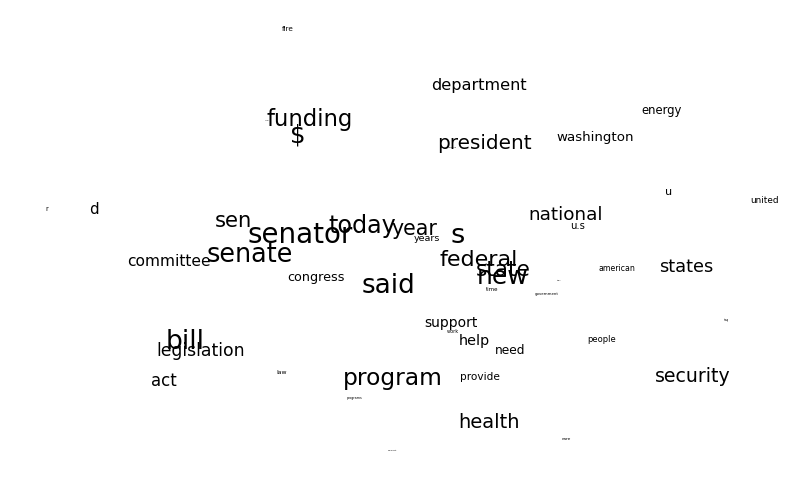

In [22]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents.

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [23]:
! pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=e041c4eafbbc92a8fb4084e113676e29903c4bb811ddc6ac5196dac63a1372ae
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing).

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [24]:
import fasttext

In [ ]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "fil9"

In [ ]:
model = fasttext.train_unsupervised(file_address, minCount=200, epoch=1)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [ ]:
model.words

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [ ]:
model.get_word_vector("the")

array([ 1.01263069e-01, -5.90192489e-02,  1.61868244e-01, -1.01701789e-01,
        2.11401746e-01,  3.44076864e-02,  1.06779106e-01, -7.01764673e-02,
       -2.77115434e-01, -3.33278567e-01, -2.25600272e-01,  2.84197815e-02,
        4.64334451e-02, -3.16535458e-02,  1.81303080e-02,  4.28940691e-02,
        1.87967479e-01, -2.95054838e-02,  7.59627223e-02,  2.25423761e-02,
        1.01923592e-01, -3.57791893e-02,  1.26660556e-01, -6.02674000e-02,
        7.77557120e-02,  2.25575492e-01,  3.91170114e-01,  2.25593746e-01,
       -2.84654528e-01, -9.91142765e-02,  6.44938052e-02,  2.01031938e-01,
       -6.81440681e-02, -1.06424704e-01,  4.65644971e-02,  1.19772151e-01,
       -6.29343688e-02,  3.63371581e-01,  4.77561578e-02,  6.11040592e-02,
       -8.36888999e-02, -4.58102636e-02, -1.21765435e-01,  9.46124494e-02,
        2.85717428e-01, -1.05698608e-01,  4.03688736e-02,  1.54146299e-01,
       -1.79450721e-01, -9.32932720e-02,  7.56328460e-03, -1.15344204e-01,
        1.28116474e-01,  

In [ ]:
model.save_model("fil9.bin")

In [ ]:
# when we want to use the model again
model = fasttext.load_model("fil9.bin")

Let's now print some vectors.

In [ ]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

[array([-0.14006662, -0.07485355,  0.319586  , -0.04093548,  0.09198429,
         0.1261278 , -0.03269082, -0.11055066,  0.04655714, -0.1326036 ,
        -0.04546691, -0.25087675,  0.18515807,  0.14625898, -0.06811476,
         0.05070682,  0.17836626,  0.04091097, -0.08842913,  0.151132  ,
         0.06338568, -0.17596854, -0.07060655,  0.1902626 , -0.0789043 ,
         0.03498681,  0.43267778,  0.12663811, -0.14121874, -0.0656484 ,
         0.05628384,  0.25708377,  0.20422208, -0.03867839,  0.10115422,
        -0.02700523, -0.11787999,  0.32505086, -0.05171636,  0.136551  ,
        -0.17223425,  0.25701734, -0.22905089, -0.04056008,  0.0833502 ,
         0.15513909,  0.37595323, -0.04926715, -0.15345646,  0.21379124,
        -0.18380232,  0.01716743, -0.1489495 , -0.15657601,  0.26150805,
        -0.14652215,  0.04858861,  0.3603034 , -0.06512161,  0.16244695,
         0.00835189, -0.01089688,  0.4704638 , -0.09488831, -0.06462533,
         0.3277814 ,  0.16953354, -0.04525212, -0.0

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [ ]:
model.get_word_vector("enviroment")

array([-2.70548295e-02,  1.50540456e-01,  2.53648639e-01, -4.23338339e-02,
        1.38390139e-01,  1.23571225e-01, -3.33544403e-01, -3.00642520e-01,
       -5.74875437e-02,  4.31564808e-01, -2.16350675e-01, -1.72045216e-01,
        6.48741424e-02,  4.55947854e-02,  1.11958481e-01, -1.84667960e-01,
        3.20180207e-01, -2.58245885e-01, -5.46172746e-02, -1.11285992e-01,
        2.84395278e-01, -2.85696507e-01, -7.29190707e-02,  1.13132909e-01,
        1.05610386e-01,  2.34497786e-01,  4.10215378e-01,  2.38320827e-01,
       -1.79288089e-01, -5.25667548e-01,  1.53210200e-02,  1.14100046e-01,
        1.30865082e-01, -4.06445339e-02,  6.67985082e-02, -4.82941747e-01,
       -1.17705710e-01,  1.97724909e-01,  2.43855476e-01,  2.99321171e-02,
       -2.99975365e-01,  2.00883836e-01, -1.07507303e-01,  3.99979770e-01,
        2.07314998e-01,  5.43931544e-01, -9.83017087e-02,  2.69692481e-01,
       -2.01667085e-01, -1.80381555e-02,  1.18486591e-01,  1.65626518e-02,
        1.53593928e-01, -

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why?

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [ ]:
import getpass
import time
import requests
import random
import pandas

In [26]:
api_key = getpass.getpass("Enter your API key: ")
headers = {"x-api-key": api_key}

Enter your API key: ··········


In [28]:
# Define the function to scrape abstract
def scrape_abstract_updated(fieldsOfStudy, year, limit_per_field=600,
                            url='https://api.semanticscholar.org/graph/v1/paper/search'):

    headers = {"x-api-key": "KOyXiGdu4t38zFJFFyuKF5jQGBGdxCSfDICseepg"}

    all_data = []

    # Start with no offset
    offset = 0
    total_papers = 0

    while total_papers < limit_per_field:
        query_params = {
            'year': year,
            'query': fieldsOfStudy,
            'fields': 'title,authors,abstract',
            'limit': 100,  # This is typically the max the API allows per request
            'offset': offset
        }

        response = requests.get(url, headers=headers, params=query_params)

        if response.status_code == 200:
            papers = response.json().get('data', [])

            # Break the loop if no papers are returned
            if not papers:
                break

            for paper in papers:
                title = paper.get('title')
                author = paper.get('authors')
                abstract = paper.get('abstract')

                if not title or not author or not abstract:
                    continue

                author_names = ', '.join([a['name'] for a in author])

                all_data.append({
                    "Year": year,
                    "FieldOfStudy": fieldsOfStudy,
                    "Title": title,
                    "Author": author_names,
                    "Abstract": abstract})

                total_papers += 1

                # Break the loop if we have reached the limit
                if total_papers >= limit_per_field:
                    break

        else:
            print(f"Request failed with status code {response.status_code}")
            break

        # Increase the offset for the next loop iteration
        offset += len(papers)

        # Sleep to respect rate limits
        sleep_time = random.randint(1,3)
        time.sleep(sleep_time)

    df = pandas.DataFrame(all_data)

    return df

In [29]:
# Scrape psychology abstract from 2003 to 2023
fieldsOfStudy = "Psychology"

all_years_data = []

for year in range(2003, 2024):
    df_year = scrape_abstract_updated(fieldsOfStudy, year)
    all_years_data.append(df_year)

# Combine all dataframes
psychology_corpus = pandas.concat(all_years_data, ignore_index=True)

# Sort the final dataframe by year
psychology_corpus = psychology_corpus.sort_values(by='Year').reset_index(drop=True)

psychology_corpus

,Year,FieldOfStudy,Title,Author,Abstract
0,2003,Psychology,Maps of Bounded Rationality: Psychology for Be...,D. Kahneman,The work cited by the Nobel committee was done...
1,2003,Psychology,DSM-Oriented and Empirically Based Approaches ...,"T. Achenbach, L. Dumenci, L. Rescorla","Department of Psychology, Bryn Mawr College Se..."
2,2003,Psychology,Does father absence place daughters at special...,"B. Ellis, J. Bates, K. Dodge, D. Fergusson, L....",The impact of father absence on early sexual a...
3,2003,Psychology,The Psychology of the Body,"E. Greene, Barbara Goodrich-Dunn",Section I: The Body Organizes Experience1. The...
4,2003,Psychology,Validation of the Female Sexual Function Index...,C. Meston,"Department of Psychology, University of Texas ..."
...,...,...,...,...,...
12595,2023,Psychology,Kin relationality and ecological belonging: a ...,"Yuria Celidwen, D. Keltner","In this article, we consider prosociality thro..."
12596,2023,Psychology,Comments on the articles dealing with individu...,J. P. Campbell,ABSTRACT Individual performance criterion meas...
12597,2023,Psychology,Deviant behavior of law enforcement officers: ...,M.N. Bochkova,Introduction. Modern Russian studies devoted t...
12598,2023,Psychology,Using energy psychology to remediate emotional...,David Feinstein,Adverse childhood experiences (ACEs) are poten...


In [9]:
# Normalize the sentences
from tqdm import tqdm
tqdm.pandas()

psychology_corpus['tokenized_sents'] = psychology_corpus['Abstract'].progress_apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
psychology_corpus['normalized_sents'] = psychology_corpus['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])

  0%|          | 0/12600 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 12600/12600 [19:08<00:00, 10.97it/s]


Save the psychology abstract corpus (with normalized sentence) to a json file:

In [10]:
psychology_corpus.to_json('psychology_corpus.json', orient='records', lines=True)
psychology_corpus = pd.read_json('psychology_corpus.json', orient='records', lines=True)

First, use `word2vec`:

In [33]:
# Here I use "skipgram" for word2vec
psychology_corpus_W2V = gensim.models.word2vec.Word2Vec(psychology_corpus['normalized_sents'].sum())

In [11]:
# Save the vector for later use
# psychology_corpus_W2V.save("psychology_corpus_WORD2Vec")
psychology_corpus_W2V = gensim.models.word2vec.Word2Vec.load("psychology_corpus_WORD2Vec")

In [109]:
# Randomly pick 60 words for visualization on a 2D plane
numWords = 40

random.seed(433)
targetWords_psychology_corpus = random.sample(psychology_corpus_W2V.wv.index_to_key, numWords)

wordsSubMatrix_psychology_corpus = []
for word in targetWords_psychology_corpus:
    wordsSubMatrix_psychology_corpus.append(psychology_corpus_W2V.wv[word])
wordsSubMatrix_psychology_corpus = np.array(wordsSubMatrix_psychology_corpus)

First, use PCA to do dimension reduction:

In [110]:
pcaWords_psychology_corpus = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix_psychology_corpus)
reducedPCA_data_psychology_corpus = pcaWords.transform(wordsSubMatrix_psychology_corpus)

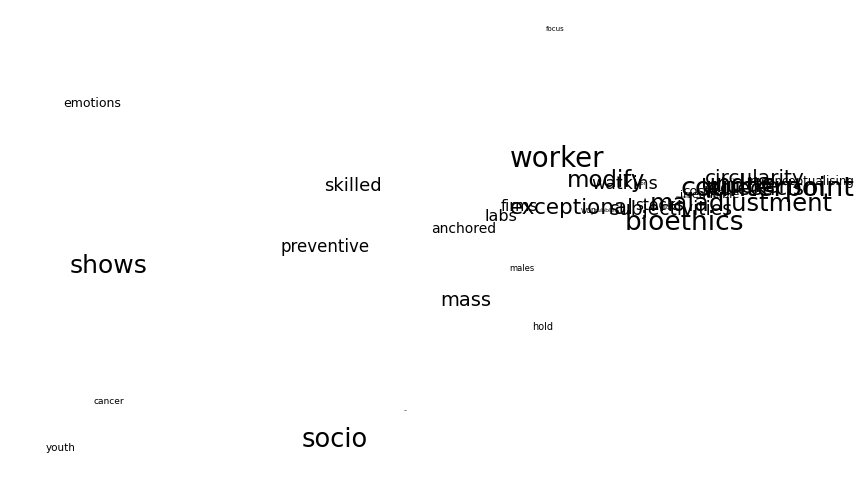

In [111]:
# Visualize
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_psychology_corpus[:, 0], reducedPCA_data_psychology_corpus[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords_psychology_corpus):
    ax.annotate(word, (reducedPCA_data_psychology_corpus[:, 0][i], reducedPCA_data_psychology_corpus[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Then, use TSNE to do dimension reduction:

In [107]:
tsne = sklearn.manifold.TSNE(n_components = 2, perplexity=30, learning_rate=200)
tsneWords_psychology_corpus = tsne.fit_transform(wordsSubMatrix_psychology_corpus)

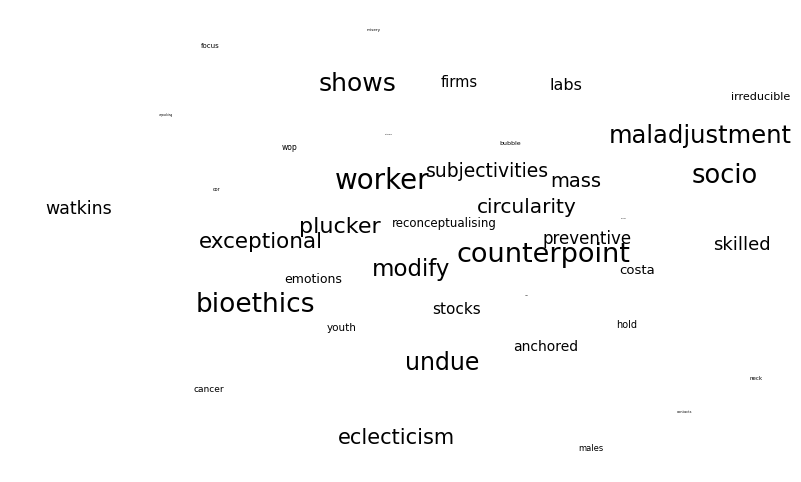

In [112]:
# Visualize
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_psychology_corpus[:, 0], tsneWords_psychology_corpus[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords_psychology_corpus):
    ax.annotate(word, (tsneWords_psychology_corpus[:, 0][i], tsneWords_psychology_corpus[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Here, I will interrogate critical word vectors within the corpus for `word2vec`:

In [75]:
target_words = ["cognitive", "memory", "disorder", "attention", "social", "developmental"]

In [76]:
# Find simialr words
similar_words_w2v = {word: psychology_corpus_W2V.wv.most_similar(word, topn=10) for word in target_words}
similar_words_w2v

{'cognitive': [('behavioural', 0.6955602169036865),
  ('developmental', 0.6781790256500244),
  ('intelligence', 0.647026002407074),
  ('perceptual', 0.6443270444869995),
  ('behavioral', 0.6441057920455933),
  ('neuroscience', 0.6342000365257263),
  ('music', 0.6275234818458557),
  ('biological', 0.6260868310928345),
  ('brain', 0.6260207295417786),
  ('computational', 0.6245361566543579)],
 'memory': [('visual', 0.7985039949417114),
  ('perceptual', 0.7900239825248718),
  ('speech', 0.762784481048584),
  ('autobiographical', 0.7489993572235107),
  ('episodic', 0.7465431690216064),
  ('perception', 0.7452394962310791),
  ('spatial', 0.7373834252357483),
  ('comprehension', 0.7274139523506165),
  ('retrieval', 0.7216001152992249),
  ('sensory', 0.7129485607147217)],
 'disorder': [('disorders', 0.9149060249328613),
  ('alcoholism', 0.9057700634002686),
  ('eating', 0.8715305328369141),
  ('disease', 0.8643463850021362),
  ('acute', 0.8537260293960571),
  ('pain', 0.8536244630813599),
  (

In [98]:
# Find word analogy
print(psychology_corpus_W2V.wv.most_similar(positive=['disorder', 'developmental'], negative=['mental'], topn=1))
print(psychology_corpus_W2V.wv.most_similar(positive=['ability', 'social'], negative=['cognitive'], topn=1))

[('psychopathology', 0.689023494720459)]
[('motivations', 0.5904983282089233)]


Then, I will try `fasttext`:

In [63]:
# Convert the normalized sentence of Abstract into a txt file
sentences = [' '.join(sentence) for sentence_list in psychology_corpus['normalized_sents'] for sentence in sentence_list]

# Write the sentences to a text file, each sentence on a new line
with open('psychology_corpus_sentences.txt', 'w') as file:
    for sentence in sentences:
        file.write(sentence + '\n')

In [64]:
# Train the model
model = fasttext.train_unsupervised('psychology_corpus_sentences.txt', model='cbow')

In [65]:
# Randomly extract a sample of 40 words from it
random.seed(42)
targetWords_psychology_corpus = random.sample(model.get_words(), numWords)

wordsSubMatrix_psychology_corpus = []
for word in targetWords_psychology_corpus:
    wordsSubMatrix_psychology_corpus.append(psychology_corpus_W2V.wv[word])
wordsSubMatrix_psychology_corpus = np.array(wordsSubMatrix_psychology_corpus)

First, use PCA to do dimension reduction:

In [66]:
pcaWords_psychology_corpus = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix_psychology_corpus)
reducedPCA_data_psychology_corpus = pcaWords.transform(wordsSubMatrix_psychology_corpus)

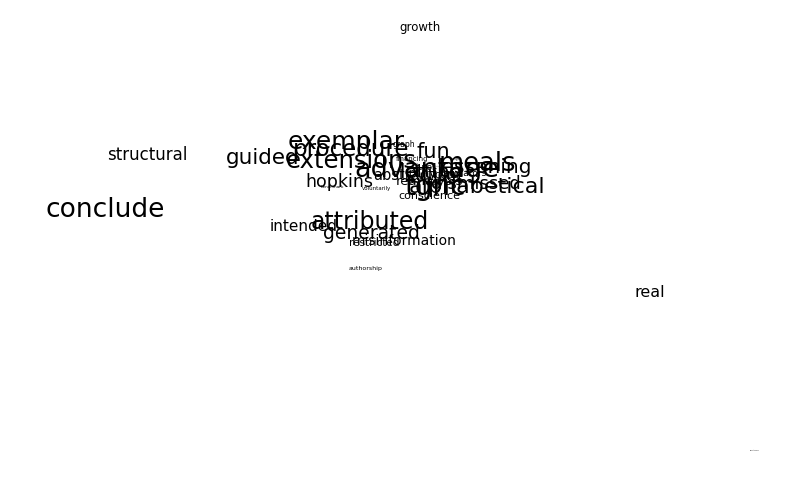

In [67]:
# Visualize
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_psychology_corpus[:, 0], reducedPCA_data_psychology_corpus[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords_psychology_corpus):
    ax.annotate(word, (reducedPCA_data_psychology_corpus[:, 0][i], reducedPCA_data_psychology_corpus[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Then, use TSNE to do dimension reduction:

In [68]:
tsne = sklearn.manifold.TSNE(n_components = 2, perplexity=30, learning_rate=200)
tsneWords_psychology_corpus = tsne.fit_transform(wordsSubMatrix_psychology_corpus)

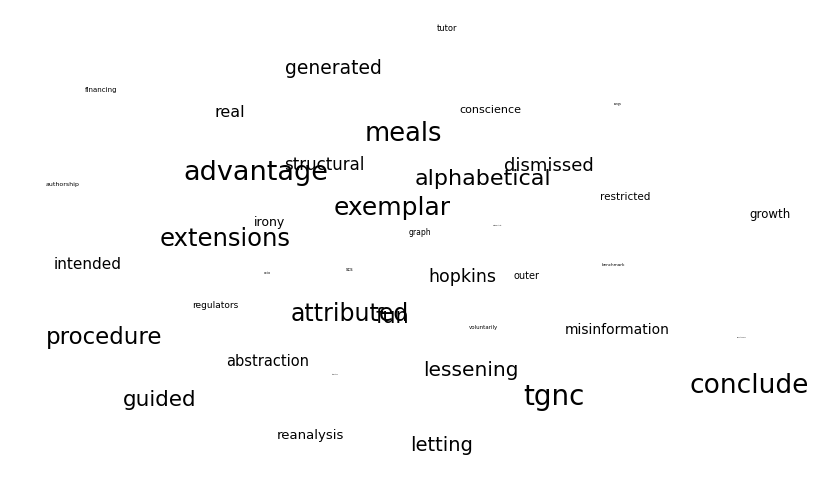

In [69]:
# Visualize
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_psychology_corpus[:, 0], tsneWords_psychology_corpus[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(targetWords_psychology_corpus):
    ax.annotate(word, (tsneWords_psychology_corpus[:, 0][i], tsneWords_psychology_corpus[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

Here, I will interrogate critical word vectors within the corpus for `fasttext`:

In [100]:
# Find simialr words
similar_words_ft = {word: model.get_nearest_neighbors(word, k=10) for word in target_words}
similar_words_ft

{'cognitive': [(0.96799236536026, 'noncognitive'),
  (0.9414506554603577, 'neurocognitive'),
  (0.9121626019477844, 'sociocognitive'),
  (0.9037158489227295, 'metacognitive'),
  (0.8413006663322449, 'engineeringcognitive'),
  (0.8325055837631226, 'neurodegenerative'),
  (0.8263337016105652, 'cognitively'),
  (0.793895959854126, 'robotic'),
  (0.7619947195053101, 'music'),
  (0.7602205872535706, 'compulsive')],
 'memory': [(0.9447013139724731, 'emory'),
  (0.9246339797973633, 'sensory'),
  (0.8866230845451355, 'sensori'),
  (0.8854328989982605, 'sensor'),
  (0.8690142035484314, 'sensorimotor'),
  (0.8548917770385742, 'speech'),
  (0.8445123434066772, 'image'),
  (0.8248124122619629, 'imagery'),
  (0.8206160664558411, 'rhythm'),
  (0.8100226521492004, 'symbol')],
 'disorder': [(0.9652374386787415, 'disorders'),
  (0.9348548054695129, 'disordered'),
  (0.8936392068862915, 'diagnosis'),
  (0.8769386410713196, 'diachronic'),
  (0.8657975196838379, 'diagnose'),
  (0.8615148067474365, 'schizo

In [103]:
# Find word analogy
import scipy

# Define a function to do addition and subtraction based on vector algebra
def analogy_ft(A, B, C, fasttext_model, topn=1):
    # Get the vectors for each word
    A_vec = fasttext_model.get_word_vector(A)
    B_vec = fasttext_model.get_word_vector(B)
    C_vec = fasttext_model.get_word_vector(C)

    # Compute the result vector
    result_vec = B_vec - A_vec + C_vec

    # Compute cosine similarity between result_vec and all word vectors in the model
    word_similarities = {word: 1 - scipy.spatial.distance.cosine(result_vec, fasttext_model.get_word_vector(word))
                         for word in fasttext_model.get_words()}

    # Sort words by similarity
    sorted_words = sorted(word_similarities.items(), key=lambda item: item[1], reverse=True)

    # Return the topn most similar words, skipping the first one as it's usually the input word itself
    return sorted_words[:topn]

print(analogy_ft('mental', 'disorder', 'developmental', model))
print(analogy_ft('cognitive', 'ability', 'social', model))

[('disorder', 0.8484290242195129)]
[('sociability', 0.8279461860656738)]


**General Discussion**:

- The simialrity analysis is what I think speaks best of the particular semantic organization of words in my corpora. For instance, for the word "developental," we can see words such as "evolutionary" and "lifespan" that makes much sense. In addition, for the word "disorder", we can see words such as "diachronic", "schizophrenic", and "diagnosis" that makes much sense. Together, they point to the semantic organization. Some words in psychology are similar in terms of morphology while others are similar in terms of semantics.

- `Fasttext` word embedding method, together with the `cbow` and `TSNE` dimension reduction (for visualization), generates the most insight both in terms of visualization results and similarity and analogy analyses. One reason behind is that `fasttext` word embedding method capture the rich morphological features of words and boasts more tolerance towards wrongly spelled words. Another reason is that `TSNE` is better than `PCA` in terms of capturing the non-linear relationship between words and words/contexts.

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [12]:
apsDF = pd.read_csv('APSabstracts1950s.csv', index_col = 0)

apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [71]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [72]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [77]:
from gensim.models.doc2vec import TaggedDocument

taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [122]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words.

In [79]:
apsD2V.docvecs[1952]

array([ 0.17181163,  1.971629  , -0.86698085,  0.6419243 ,  0.6129144 ,
        1.1686362 , -0.3790102 ,  0.26621646,  1.1049868 , -0.9640349 ,
       -1.1178436 , -0.8070163 ,  0.5185582 , -0.40895084, -0.9865325 ,
        0.8371079 , -0.29231405,  0.29161775,  0.59756553, -1.2935795 ,
        1.1704687 ,  1.6722871 ,  0.7961489 ,  0.82660705, -1.9275316 ,
       -0.8206311 ,  1.6623964 ,  0.41333857,  0.2655596 ,  0.8708195 ,
        0.42974502, -0.23455943, -0.5169039 ,  1.1584927 , -1.7233324 ,
       -0.36329538,  1.0890714 , -0.32179102, -1.0614524 , -1.9596035 ,
        1.6232164 , -0.77070904, -1.3951645 ,  0.79453546, -1.867166  ,
        0.2022315 , -1.9590666 , -1.1133137 , -1.966229  ,  0.8067562 ,
       -1.500061  , -0.11287843,  0.65433943, -0.17740184, -1.8157912 ,
       -1.7303252 ,  0.24115665,  0.34796846, -0.23800786, -0.6183959 ,
       -1.6320906 , -0.8387875 ,  1.078607  , -0.61191416, -1.1424114 ,
       -1.4994903 ,  0.839549  ,  0.27440006, -2.2325883 ,  1.12

The words can still be accessed in the same way:

In [80]:
apsD2V['atom']

array([-1.4242754 , -1.322619  ,  1.1054469 , -0.7193412 ,  1.1555543 ,
        0.11050887, -0.3654697 ,  0.980828  ,  0.19256249,  0.14131209,
       -0.8809601 ,  0.15684813, -0.15309611,  0.51935315, -0.44385433,
        1.7055346 , -0.38666755,  1.6949948 ,  0.12340868, -1.66729   ,
       -2.2019672 ,  0.9542264 ,  0.21236256,  1.3630347 ,  0.02182803,
       -0.14283715,  0.10210929,  0.12395934, -0.50225896,  0.78969747,
        0.5718688 , -0.7196917 , -0.21970068,  0.49117354, -0.65353596,
       -0.5962321 ,  0.42258784, -0.17108521,  0.2493383 , -0.67798394,
        1.5230786 ,  0.57053274, -1.1081583 , -1.5977118 ,  1.2860764 ,
       -0.03339134, -0.85451806,  0.8137517 , -0.36353505,  1.7132565 ,
        0.21995115,  0.45482036,  1.620533  , -0.48533657,  0.61261624,
        0.11344907,  0.15075028, -0.82269675,  1.6338406 ,  0.142779  ,
       -1.040129  , -0.38633734,  0.393176  , -0.451689  , -1.3700595 ,
       -0.6088315 , -0.30284402, -0.937112  ,  0.06554045,  0.07

We can still use the ``most_similar`` command to perform simple semantic equations:

In [81]:
apsD2V.wv.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7831116318702698)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**!

In [82]:
apsD2V.wv.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('obey', 0.698609471321106)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra:

In [83]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.45383012]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [84]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.1545', 0.5275902152061462),
 ('10.1103/PhysRev.112.334', 0.446575403213501),
 ('10.1103/PhysRev.115.678', 0.41805168986320496),
 ('10.1103/PhysRev.114.644', 0.412951797246933),
 ('10.1103/PhysRev.104.584', 0.40032005310058594)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

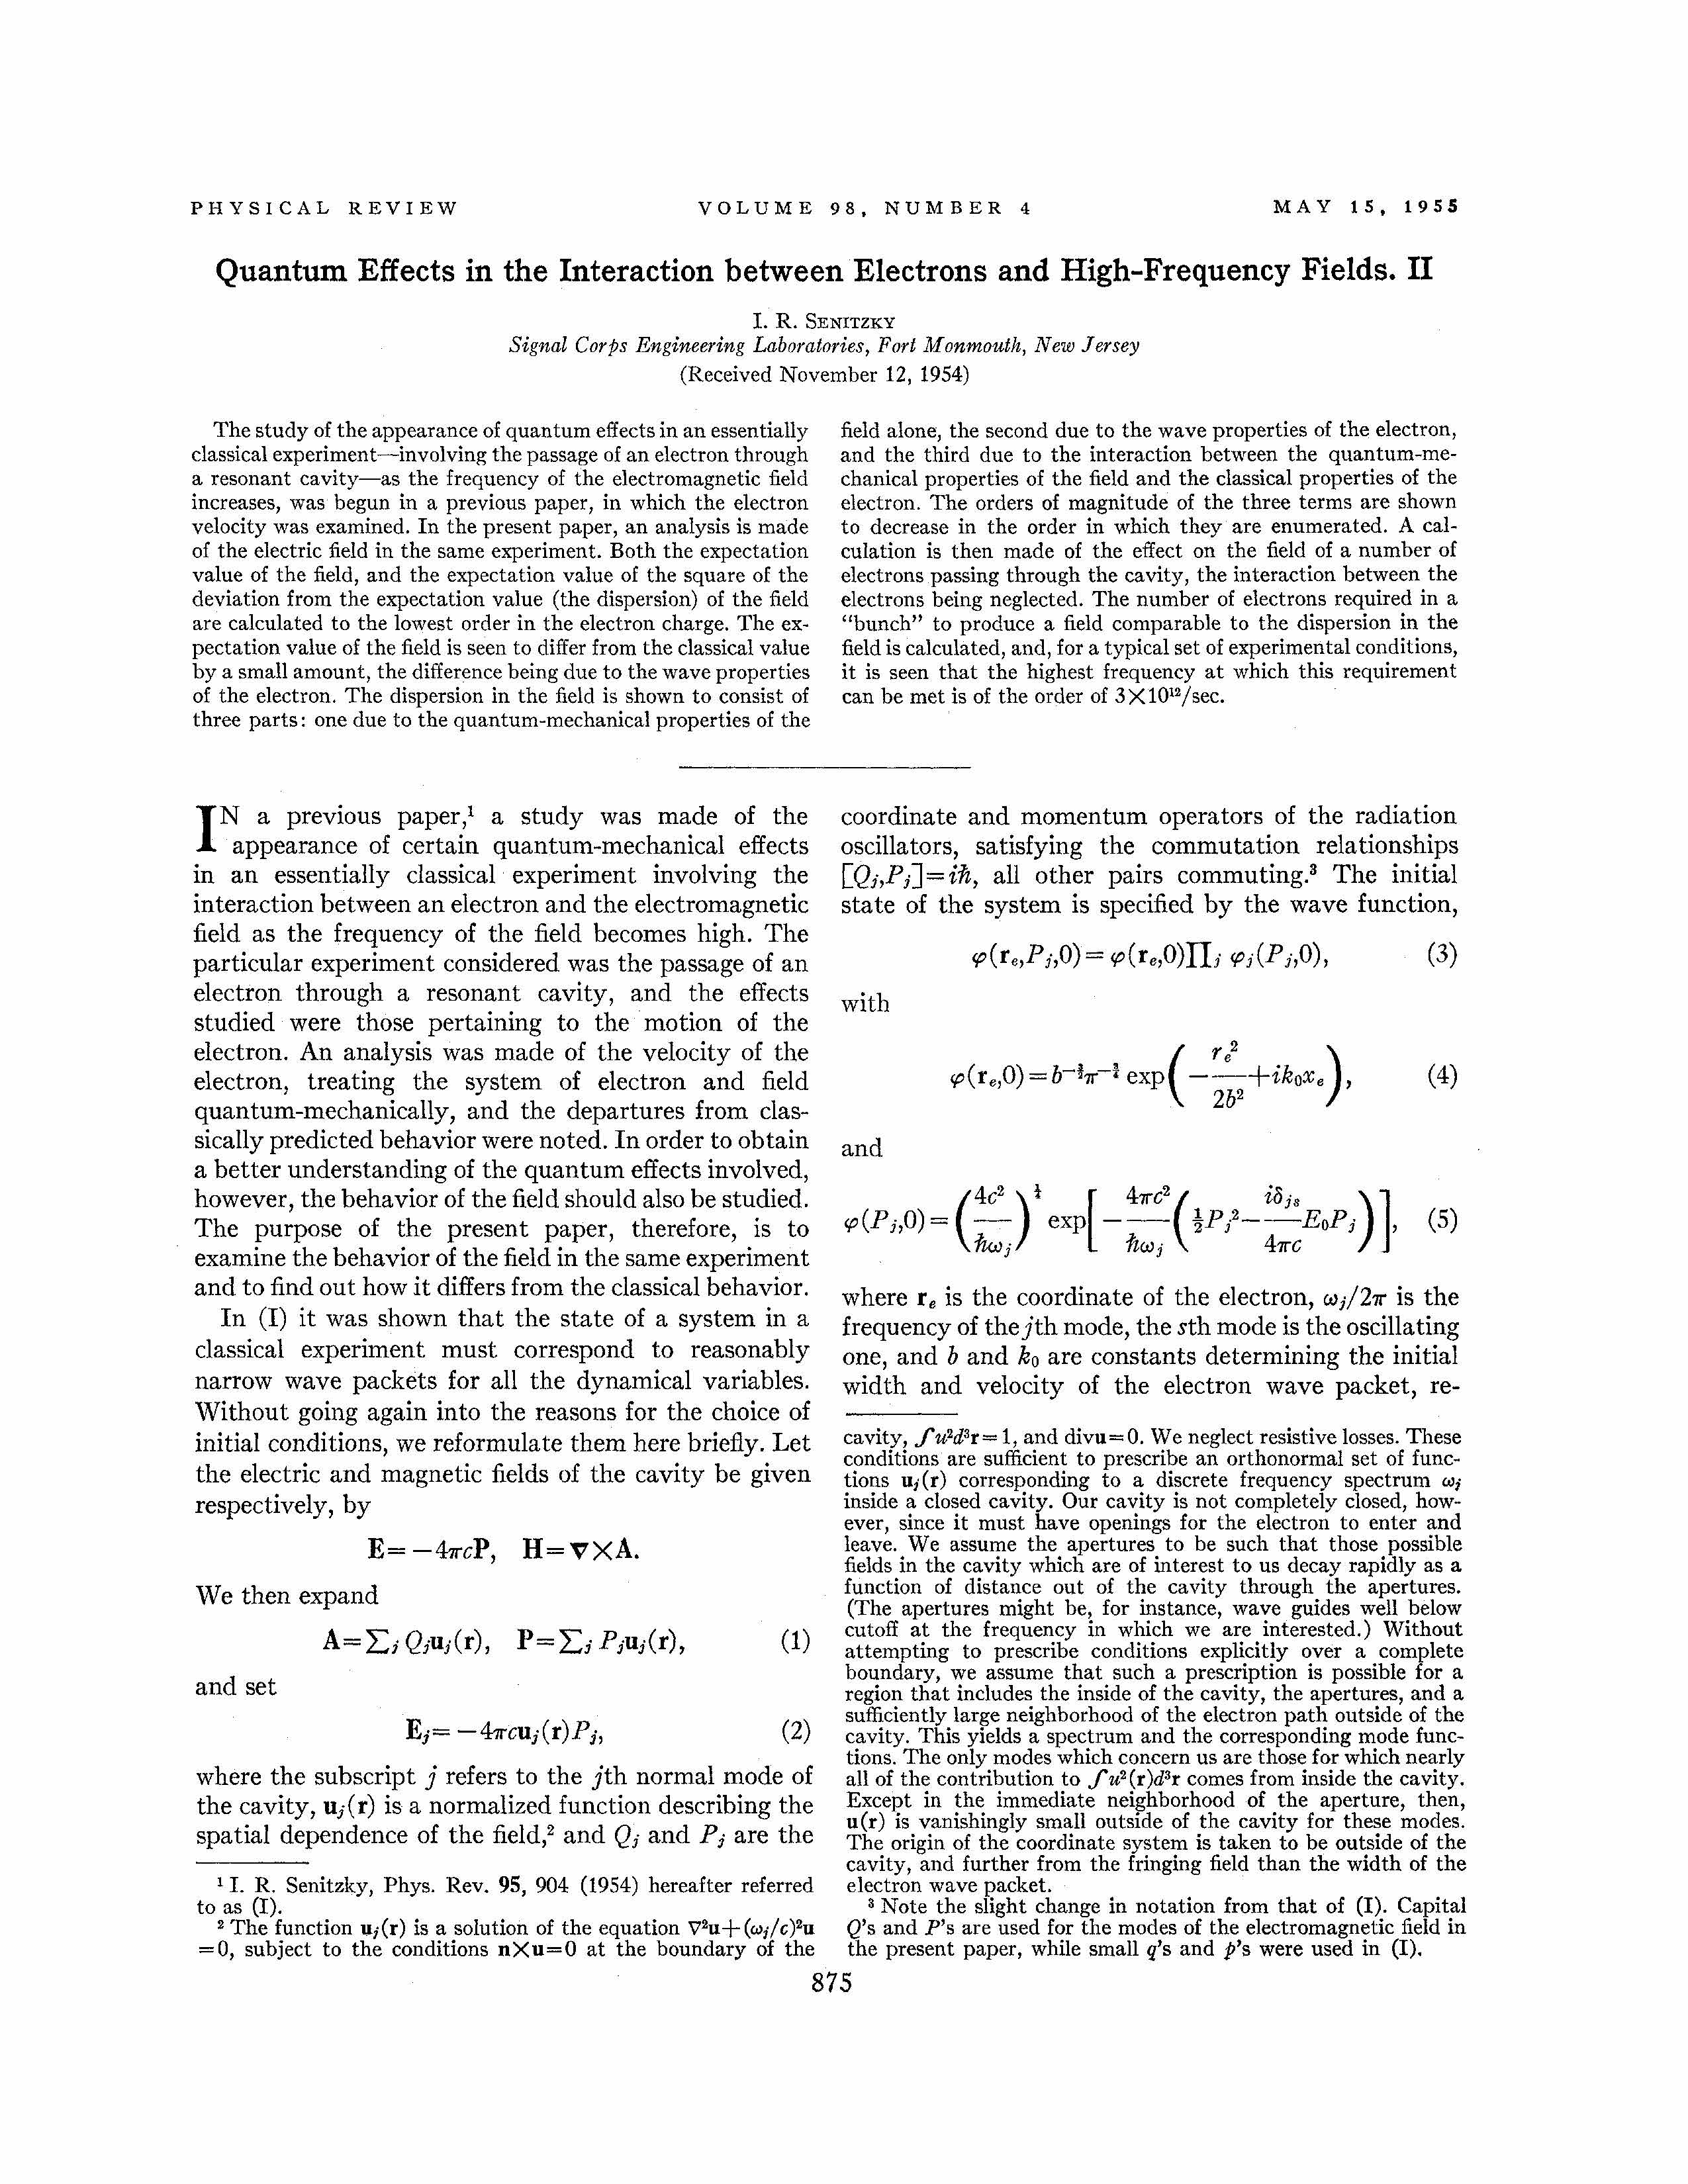

In [ ]:
from IPython.display import Image
Image("PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [85]:
apsD2V.wv.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5)

[('microscope', 0.6178924441337585),
 ('electromagnetic', 0.594433605670929),
 ('attainable', 0.5913365483283997),
 ('loeb', 0.5861228108406067),
 ('radio', 0.5816642642021179)]

We can even look for documents most like a query composed of multiple words:

In [86]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.102.466', 0.5027457475662231),
 ('10.1103/PhysRev.115.349', 0.49910175800323486),
 ('10.1103/PhysRev.108.809', 0.4848974049091339),
 ('10.1103/PhysRev.91.885', 0.48095202445983887),
 ('10.1103/PhysRev.110.451', 0.47701919078826904)]

Now let's plot some words and documents against one another with a heatmap:

In [87]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

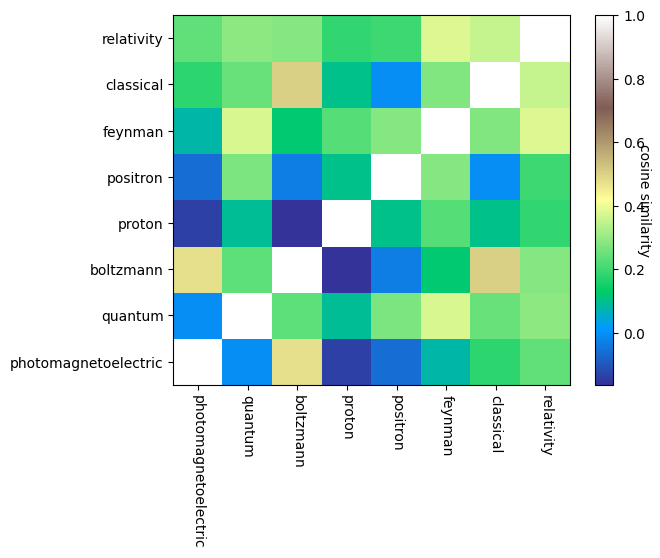

In [88]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [89]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

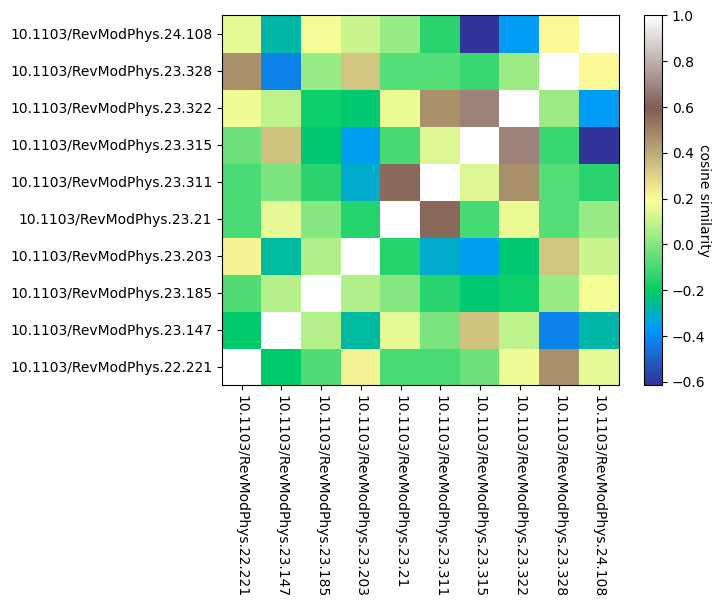

In [90]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [91]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

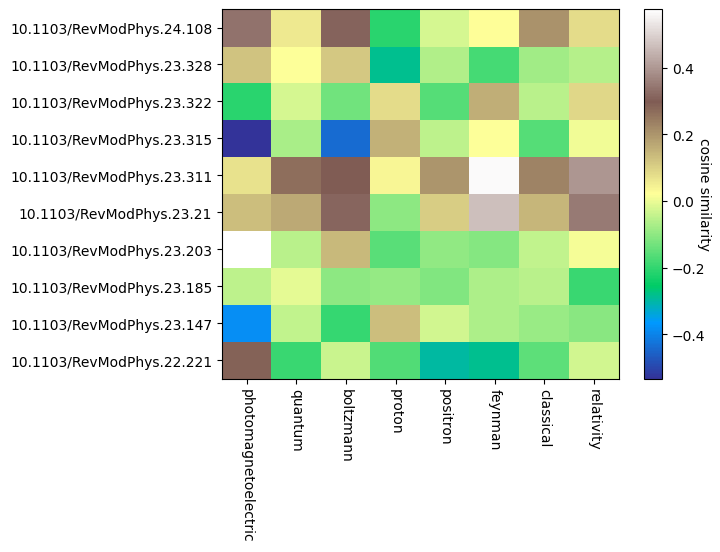

In [92]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [93]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [12]:
keywords = ["attention", "bias", "cognitive", "lifespan", "trend", "neuron", "memory", "social", "perception"]

In [13]:
psychology_corpus['tokenized_words'] = psychology_corpus['Abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
psychology_corpus['normalized_words'] = psychology_corpus['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [56]:
taggedDocs = []
for index, row in psychology_corpus.iterrows():
    # Still doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    unique_identifier = row['Title']

    # Include the unique identifier as the first or only tag if you want to use it to retrieve vectors
    tags = [unique_identifier] + docKeywords  # Unique identifier is now the first item in tags

    # Create the TaggedDocument
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words=row['normalized_words'], tags=tags))

psychology_corpus['TaggedAbstracts'] = taggedDocs

In [57]:
psychology_corpus.head()

,Year,FieldOfStudy,Title,Author,Abstract,tokenized_words,normalized_words,TaggedAbstracts
0,2003,Psychology,Maps of Bounded Rationality: Psychology for Be...,D. Kahneman,The work cited by the Nobel committee was done...,"[The, work, cited, by, the, Nobel, committee, ...","[work, cited, nobel, committee, jointly, amos,...","([work, cited, nobel, committee, jointly, amos..."
1,2003,Psychology,DSM-Oriented and Empirically Based Approaches ...,"T. Achenbach, L. Dumenci, L. Rescorla","Department of Psychology, Bryn Mawr College Se...","[Department, of, Psychology, Bryn, Mawr, Colle...","[department, psychology, bryn, mawr, college, ...","([department, psychology, bryn, mawr, college,..."
2,2003,Psychology,Does father absence place daughters at special...,"B. Ellis, J. Bates, K. Dodge, D. Fergusson, L....",The impact of father absence on early sexual a...,"[The, impact, of, father, absence, on, early, ...","[impact, father, absence, early, sexual, activ...","([impact, father, absence, early, sexual, acti..."
3,2003,Psychology,The Psychology of the Body,"E. Greene, Barbara Goodrich-Dunn",Section I: The Body Organizes Experience1. The...,"[Section, I, The, Body, Organizes, Experience1...","[section, body, organizes, experience1, psycho...","([section, body, organizes, experience1, psych..."
4,2003,Psychology,Validation of the Female Sexual Function Index...,C. Meston,"Department of Psychology, University of Texas ...","[Department, of, Psychology, University, of, T...","[department, psychology, university, texas, au...","([department, psychology, university, texas, a..."


In [58]:
psychology_corpus_D2V = gensim.models.doc2vec.Doc2Vec(psychology_corpus['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

In [59]:
# Save the model for future use
psychology_corpus_D2V.save('psychology_corpus_D2V')

In [60]:
psychology_corpus_D2V[keywords[0]]

array([ 2.0096033 , -3.25494   ,  0.3503406 , -2.6707897 ,  1.8266952 ,
        3.0265005 ,  0.72651356, -2.3274412 ,  1.033993  , -1.882427  ,
       -0.48290446, -0.7243174 , -1.1795006 ,  0.71258235, -3.04185   ,
       -2.5114799 ,  1.8439687 ,  2.6389859 , -2.1040947 ,  3.298458  ,
       -0.13691796,  2.8466508 , -2.3130841 ,  1.4692621 ,  0.64015824,
        1.5599067 ,  1.49094   , -1.3263618 , -1.4178334 ,  1.3980495 ,
        1.8014585 ,  2.312198  , -1.9165174 , -0.1024147 , -2.241296  ,
        0.25877702, -0.6638854 ,  0.98020715,  2.125756  ,  0.7410063 ,
       -0.19976343, -0.53834784,  0.35599613,  1.0572532 ,  0.41566843,
        2.270602  ,  3.3956702 ,  0.2841336 , -1.9608245 , -0.00992891,
        0.41045186, -0.41439927,  0.7952121 , -0.269985  ,  2.2156377 ,
       -0.70941514, -0.70305634, -0.11829279, -0.9085079 ,  2.6373158 ,
       -1.08184   , -1.4497665 , -0.39245296, -1.042203  ,  0.20553666,
       -0.38442943, -1.700642  , -0.0854692 , -2.8673222 ,  0.68

Use the ``most_similar`` command to perform simple semantic equations:

In [61]:
import itertools
import random

random.seed(42)
pairs = list(itertools.combinations(keywords, 3))
random.shuffle(pairs)

# Randomly pick three-word pairs to perform semantic equation
for p in pairs[::10]:
  print(f"{p[0]} is to {p[2]} as {p[1]} to: \n")
  print(psychology_corpus_D2V.wv.most_similar(positive = [p[0], p[1]], negative = p[2], topn = 1))
  print("\n")

cognitive is to social as memory to: 

[('motor', 0.50909024477005)]


lifespan is to perception as memory to: 

[('psychobiological', 0.5733289122581482)]


lifespan is to social as trend to: 

[('advancements', 0.5324222445487976)]


bias is to social as cognitive to: 

[('errors', 0.47617873549461365)]


bias is to perception as lifespan to: 

[('stemming', 0.5032321810722351)]


cognitive is to perception as neuron to: 

[('shm', 0.5716168880462646)]


trend is to social as memory to: 

[('indication', 0.4538801610469818)]


trend is to memory as neuron to: 

[('accelerating', 0.5644505620002747)]


bias is to neuron as lifespan to: 

[('diversity', 0.4881034195423126)]




Calculate the distance between a word and documents in the dataset:

In [62]:
for i in keywords:
  print(f"Most similar documents to the word {i}: \n")
  print(psychology_corpus_D2V.docvecs.most_similar([psychology_corpus_D2V[i]], topn=3))
  print("\n")

Most similar documents to the word attention: 

[('attention', 0.6965131759643555), ('Personnel psychology: performance evaluation and pay for performance.', 0.4943733811378479), ('The selective disruption of spatial working memory by eye movements', 0.46726399660110474)]


Most similar documents to the word bias: 

[('bias', 0.7684893012046814), ('Normative Bias and Adaptive Challenges: A Relational Approach to Coalitional Psychology and a Critique of Terror Management Theory', 0.5313582420349121), ('Contextual sensitivity in scientific reproducibility', 0.522936999797821)]


Most similar documents to the word cognitive: 

[('Social Psychology and Neuroscience: Strange Bedfellows or a Healthy Marriage?', 0.5508804321289062), ('Attention in Psychology, Neuroscience, and Machine Learning', 0.4759507179260254), ('Pay attention! A review of visual attentional expertise in sport', 0.47070473432540894)]


Most similar documents to the word lifespan: 

[('The Making of Developmental Psycholo

Find words most similar to this document:

In [63]:
import re

# Generate a list of article titles that contain the keywords specified earlier
key_articles = []

re_pattern = '|'.join(re.escape(keyword) for keyword in keywords)
for index, row in psychology_corpus.iterrows():
  if re.search(re_pattern, row["Title"]):
    key_articles.append(row["Title"])
  if len(key_articles) >= len(keywords):
    break

key_articles

['Dialogicality and social representations: The dynamics of mind.',
 'Risk: from perception to social representation.',
 'Metaphor and metonymy at the crossroads : a cognitive perspective',
 'A comparison of macaque behavior and superior colliculus neuronal activity to predictions from models of two-choice decisions.',
 'Some problems with social cognition models: a pragmatic and conceptual analysis.',
 'Social psychology of mental health: the social structure and personality perspective.',
 'Inner lives and social worlds : readings in social psychology',
 'The potential relevances of biology to social inquiry',
 'Four routes of cognitive evolution.']

In [65]:
for i in key_articles:
    print(f"Words similar to article '{i}':")

    # Retrieve the vector for the document with identifier 'i'
    doc_vector = psychology_corpus_D2V.docvecs[i]  # 'i' should be a tag used during the Doc2Vec training

    # Find words that are most similar to the document vector
    similar_words = psychology_corpus_D2V.wv.most_similar([doc_vector], topn=5)

    # Print the similar words and their similarity scores
    for word, similarity in similar_words:
        print(f"    {word}: {similarity}")
    print("\n")

Words similar to article 'Dialogicality and social representations: The dynamics of mind.':
    counterfactual: 0.641569972038269
    symbolic: 0.6191838979721069
    hayek: 0.6008864641189575
    cognitivism: 0.5963356494903564
    logical: 0.5937345623970032


Words similar to article 'Risk: from perception to social representation.':
    normalization: 0.5322347283363342
    dress: 0.4768732786178589
    uncertainty: 0.4537827670574188
    explanatory: 0.4022165834903717
    account: 0.39923837780952454


Words similar to article 'Metaphor and metonymy at the crossroads : a cognitive perspective':
    essays: 0.6798387169837952
    edited: 0.6710783839225769
    written: 0.646432638168335
    editions: 0.6437100768089294
    texts: 0.6432715058326721


Words similar to article 'A comparison of macaque behavior and superior colliculus neuronal activity to predictions from models of two-choice decisions.':
    drift: 0.891488790512085
    conditionals: 0.8662848472595215
    averaging

Look for documents most like a query composed of multiple words:

In [73]:
psychology_corpus_D2V.docvecs.most_similar([psychology_corpus_D2V['cognitive']+psychology_corpus_D2V['attention']+psychology_corpus_D2V['bias']], topn=5 )

[('attention', 0.49126002192497253),
 ('Interpersonal Emotion Regulation: A Review of Social and Developmental Components',
  0.47662869095802307),
 ('Understanding Priming Effects in Social Psychology: An Overview and Integration',
  0.473267525434494),
 ('The centrality of social image in social psychology', 0.4555116593837738),
 ('The potential of biophysiology for understanding motivation, engagement and learning experiences.',
  0.4327312111854553)]

Plot a heatmap of similarities between keywords:

In [66]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = psychology_corpus_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, psychology_corpus_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

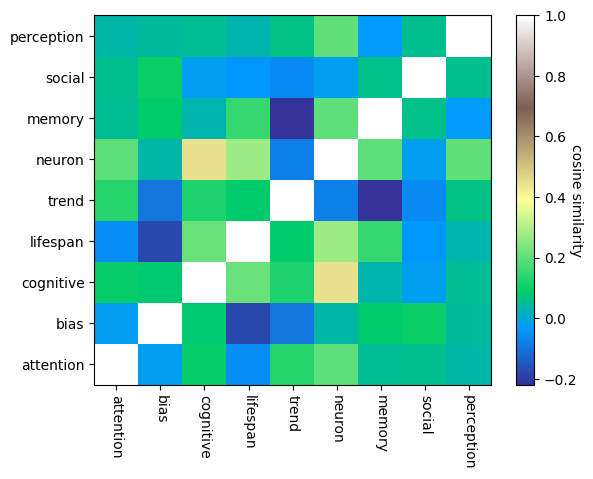

In [67]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Plot a heatmap of similarities between the selected articles:

In [68]:
heatmapMatrixD = []

for tagOuter in key_articles:
    column = []
    tagVec = psychology_corpus_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in key_articles:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, psychology_corpus_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

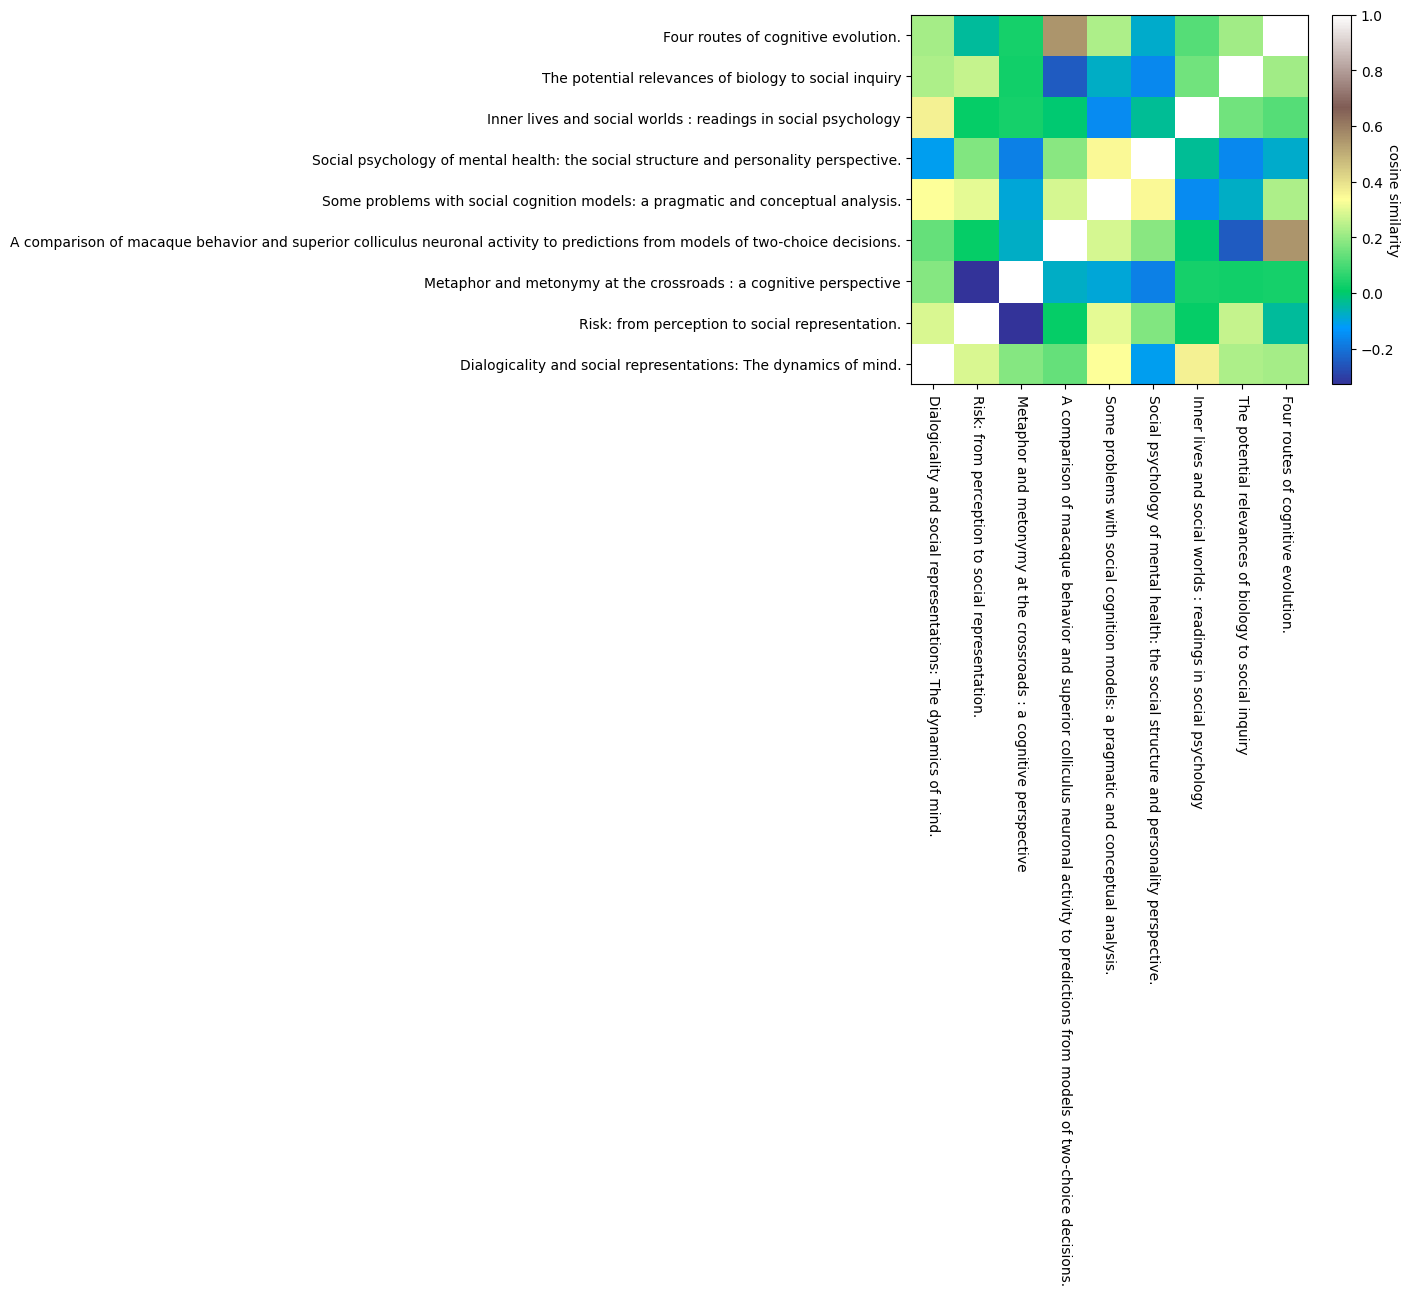

In [70]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(key_articles, minor=False, rotation=270)
a = ax.set_yticklabels(key_articles, minor=False)

Plot a heatmap of similarities between keywords and selected articles:

In [71]:
heatmapMatrixC = []

for tagOuter in key_articles:
    column = []
    tagVec = psychology_corpus_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in key_articles:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, psychology_corpus_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

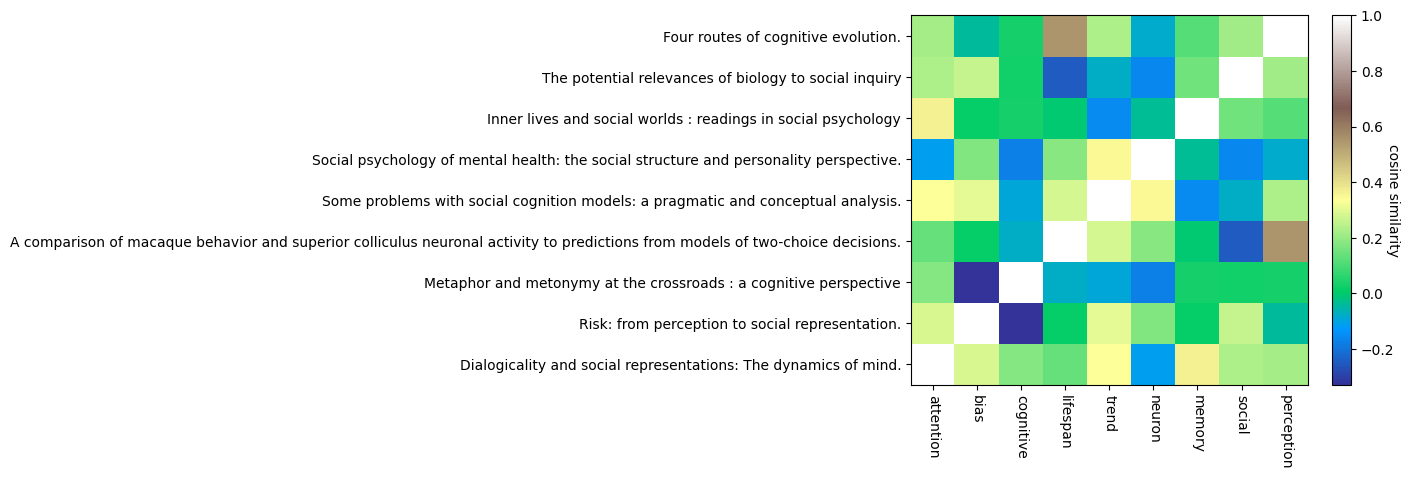

In [72]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(key_articles, minor=False)

**General Discussion**:

The results above not only demonstrate the interesting word analogies in psychology but also yield insights into the word-document and, furthermore, document-document relationships.

To begin with, although I chose words spanning from multiple sub-fields of psychology to do the word analogy analysis, some combinations here surprsingly makes some sense. For instance, the output that lifespan is to social as trend to advancements highlight one specific aspect of an overaching concept (here, lifespan and trend), i.e., social aspect of lifespan and advancements in trend (of course, there could be failures). Also, the output that bias is to social as cognitive to errors highlights the use of an adjective to a noun with negative connotations and the fact that the phrase "cognitive errors" makes sense suggests that this (domain-specific) adjective with negative noun combination may be a common word usage in psychology papers.

Moreover, when looking at word-document and, furthermore, document-document relationships, we can notice one important trend. Specifically, by randomly select a few words spanning from multiple sub-fields of psychology, one can easily deduce which subfield one paper belongs to by directly conducting similariy analysis with just a few words in a subfield where there are hundreds of words commonly used. For instance, if we take a look at the heatmaps above, we can easily tell that the paper named "The potential relevance of biology to social enquiry" is the less relevant to lifespan than to neuron (which is more related to biology).


# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles.

In [13]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [14]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [15]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

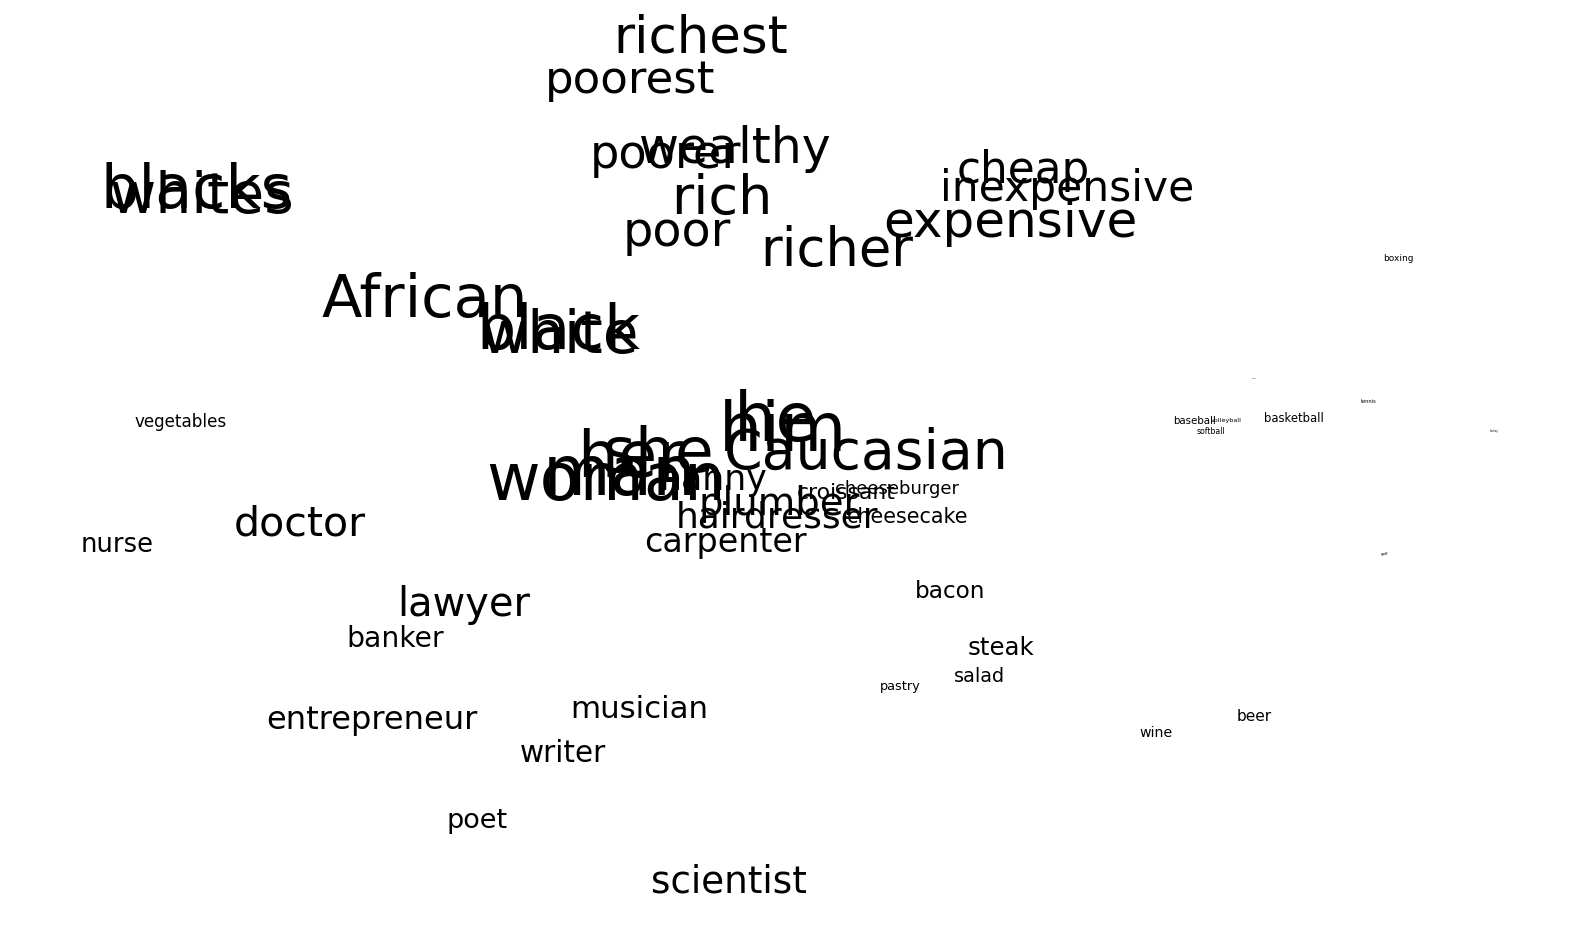

In [16]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions.

In [26]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [18]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [19]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [20]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [21]:
OCCdf = makeDF(nytimes_model, Occupations)
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [22]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

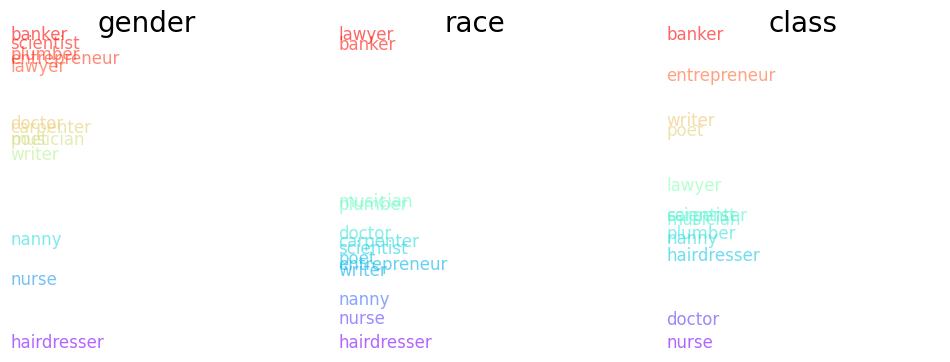

In [23]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

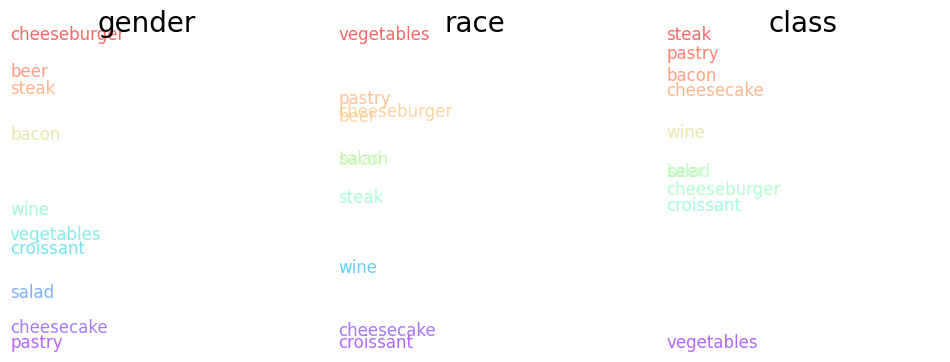

In [24]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

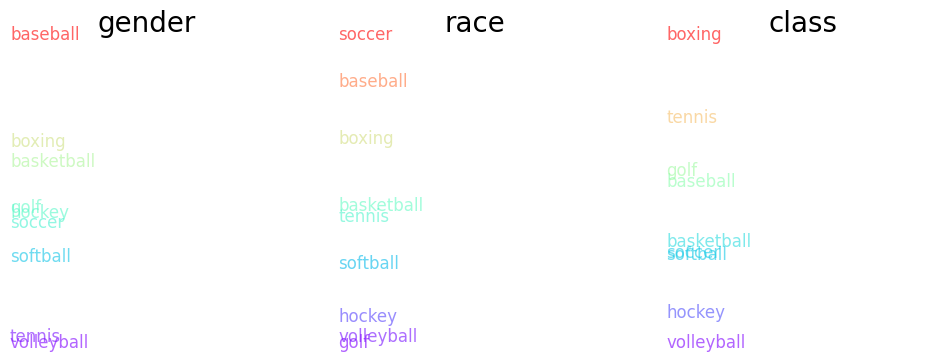

In [25]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why?

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

Here, I choose three dimensions:
1. Quantitative_Qualitative
2. Positive_Negative
3. Individual_Social

In [29]:
# Update the function to deal with Word2Vec model
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model.wv[x]) for x in positives]) - sum([normalize(model.wv[y]) for y in negatives])
    return diff

In [31]:
Quantitative_Qualitative = dimension(psychology_corpus_W2V, ['quantitative'], ['qualitative'])

Positive_Negative = dimension(psychology_corpus_W2V, ['positive'], ['negative'])

Individual_Social = dimension(psychology_corpus_W2V, ['individual'], ['social'])

Here, I define the words related to three sub-fields of psychology:

In [32]:
Cognitive_Psychology = ["memory", "attention", "perception", "representation", "intelligence"]

IO_Psychology = ["leadership", "motivation", "performance", "recruitment", "climate"] # Industrial and Organizational PScyhology

Social_Psychology  = ["prejudice", "persuaion", "conformity", "friendship", "altruism"]

Define a function to project words in a word list to each of the three dimensions.

In [33]:
# Update the function to handle Word2Vec
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        if word in model.wv:
            word_vec = model.wv[word].reshape(1, -1)
            g.append(sklearn.metrics.pairwise.cosine_similarity(word_vec, Quantitative_Qualitative.reshape(1, -1))[0][0])
            r.append(sklearn.metrics.pairwise.cosine_similarity(word_vec, Positive_Negative.reshape(1, -1))[0][0])
            c.append(sklearn.metrics.pairwise.cosine_similarity(word_vec, Individual_Social.reshape(1, -1))[0][0])
        else:
            g.append(None)
            r.append(None)
            c.append(None)
    df = pd.DataFrame({'Quantitative_Qualitative': g, 'Positive_Negative': r, 'Individual_Social': c}, index=word_list)
    return df


Get the projections.

In [35]:
Cog_df = makeDF(psychology_corpus_W2V, Cognitive_Psychology)
IO_df = makeDF(psychology_corpus_W2V,IO_Psychology)
Social_df = makeDF(psychology_corpus_W2V, Social_Psychology)

Define some useful functions for plotting.

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot Cognitive Psychology words in each of the three dimensions:

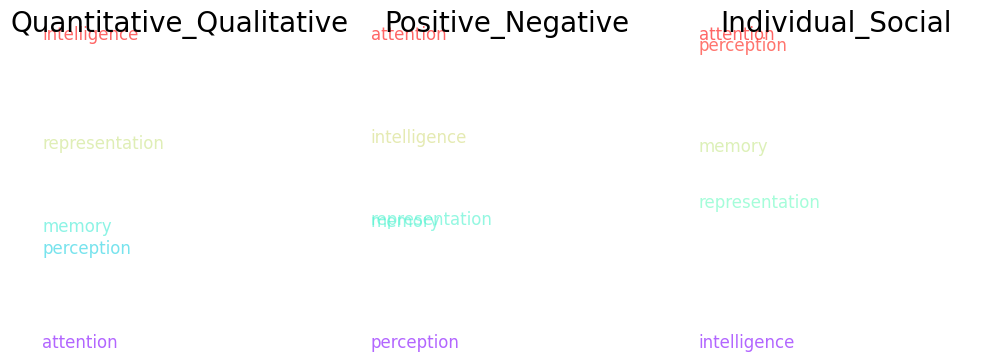

In [36]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Cog_df, 'Quantitative_Qualitative')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Cog_df, 'Positive_Negative')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Cog_df, 'Individual_Social')
plt.show()

Plot IO Psychology words in each of the three dimensions.

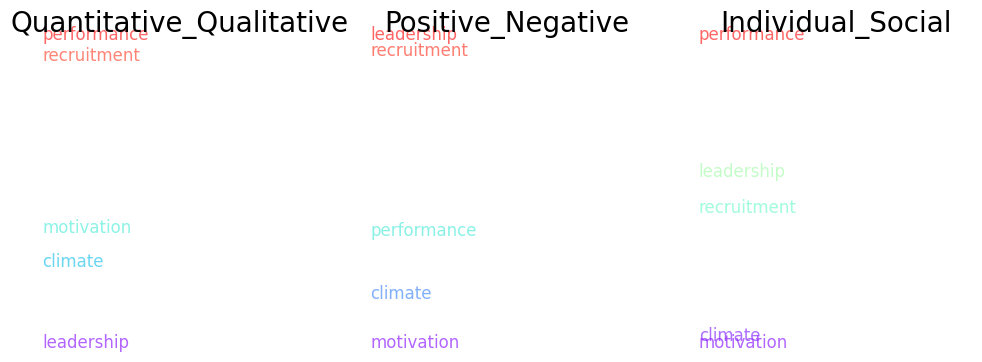

In [37]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, IO_df, 'Quantitative_Qualitative')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, IO_df, 'Positive_Negative')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, IO_df, 'Individual_Social')
plt.show()

Plot Social Psychology words in each of the three dimensions.

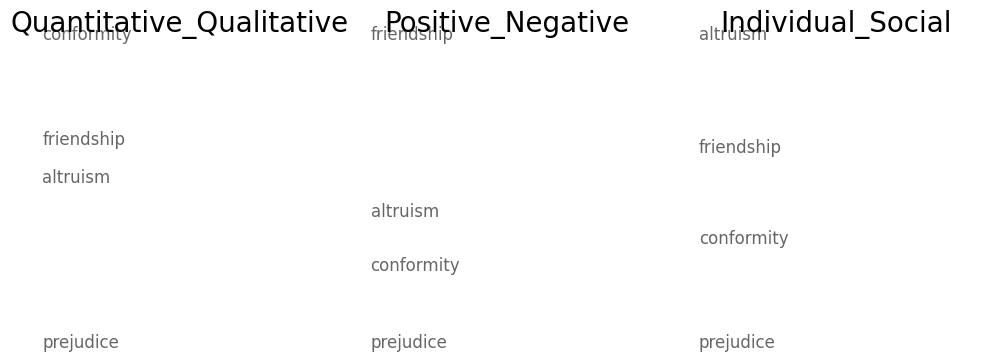

In [38]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Social_df, 'Quantitative_Qualitative')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Social_df, 'Positive_Negative')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Social_df, 'Individual_Social')
plt.show()

**General Discussion**:

From the results above, we can tell that some dimensions are better at distinguishing the sub-fields of psychology (instead of a one-size-fit-all condition that explains the most variation in the projection for all sub-fields). For instance, quantitative-qualitative dimension best explains IO Psychology: performance and recruitment are related to the more concrete measurement and operations while climate and leadership are more abstract and is best described qualitatively. In addition, positive-negative dimension seems to best explains Social Psycholigy: friendship often carries positive connations while conformity and prejudice often carries negative connotation in real life (though altruism should be more on the positive side instead of currently standing in the middle). Finally, I think all three dimensions does not offer a great explanation for cognitive psychology, which also makes some sense because all these dimensions are usually used to classify cognitive psychology constructs.


# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf).

In [39]:
import copy

In [40]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = calc_syn0norm(in_base_embed)
    # other_vecs = calc_syn0norm(in_other_embed)
    base_vecs= [in_base_embed.wv.get_vector(w,norm=True) for w in set(in_base_embed.wv.index_to_key)]
    other_vecs= [in_other_embed.wv.get_vector(w,norm=True) for w in set(in_other_embed.wv.index_to_key)]

    # just a matrix dot product with numpy
    m = np.array(other_vecs).T.dot(np.array(base_vecs))
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors =(np.array(other_vecs)).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count")  + m2.wv.get_vecattr(w, "count") ,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        new_arr = [m.wv.get_vector(w,norm=True) for w in common_vocab]

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i={}
        for new_index,word in enumerate(common_vocab):
            new_vocab.append(word)
            k2i[word]=new_index
        m.wv.index_to_key=new_vocab
        m.wv.key_to_index=k2i
        m.wv.vectors=np.array(new_arr)

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [41]:
apsDF = pd.read_csv("APSabstracts1950s.csv", index_col=0)

Prepare for wor2vec:

In [42]:
apsDF['tokenized_sents'] = apsDF['abstract'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
apsDF['normalized_sents'] = apsDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [43]:
apsDF.head()

,copyrightYear,doi,abstract,tokenized_sents,normalized_sents
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...,"[[A, summarizing, account, is, given, of, the,...","[[summarizing, account, give, research, barium..."
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...,"[[New, tables, of, coulomb, functions, are, pr...","[[new, table, coulomb, function, present, intr..."
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...,"[[Ionization, by, electron, impact, in, diatom...","[[ionization, electron, impact, diatomic, gas,..."
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...,"[[It, is, shown, that, the, conductivity, in, ...","[[show, conductivity, ohmic, cuprous, oxide, l..."
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...,"[[The, factorization, method, is, an, operatio...","[[factorization, method, operational, procedur..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [44]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [45]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [46]:
rawEmbeddings, comparedEmbeddings = compareModels(apsDF, 'copyrightYear')

In [47]:
rawEmbeddings.keys()

dict_keys([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [48]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                                                                             np.expand_dims(embed.wv[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

Lets look at a couple words:

radioactive


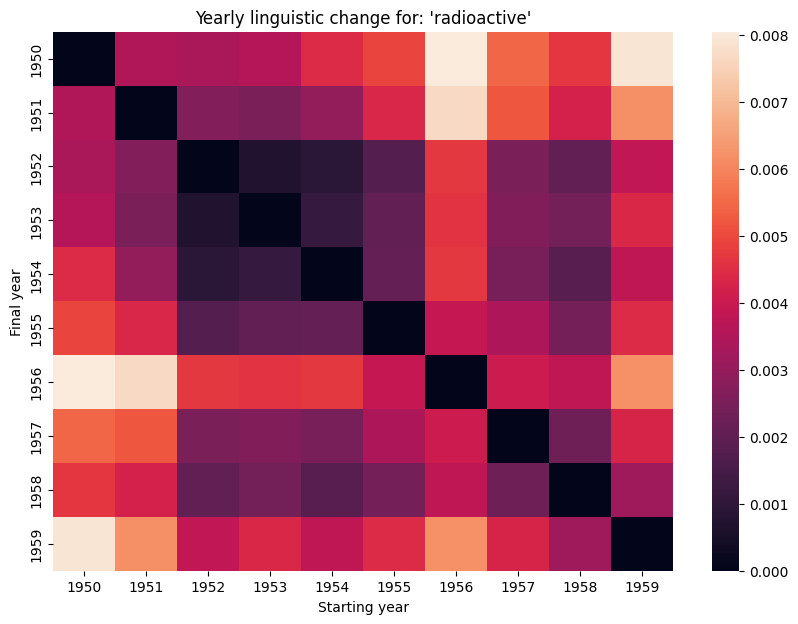

In [49]:
targetWord = 'radioactive'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

area


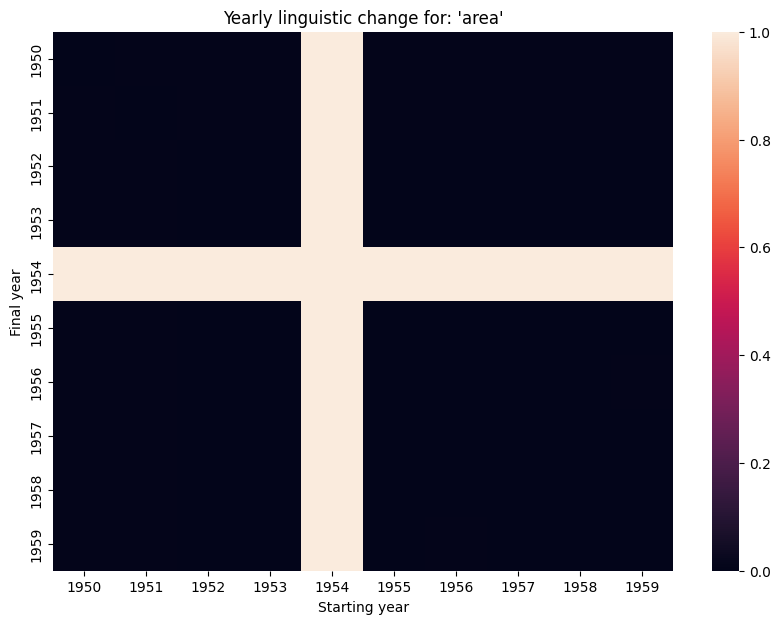

In [50]:
targetWord = 'area'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [51]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0].wv[word], axis = 0), np.expand_dims(embed.wv[word], axis = 0))[0,0])
        except:
            pass
    return np.mean(dists)

def findMostDivergent(embeddingsDict):
    original_words = comparedEmbeddings[1950][0].wv.index_to_key
    for embeds in embeddingsDict.values():
        for embed in embeds:
            original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)


In [52]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 843 words to compare


The most divergent words are:

In [53]:
wordDivergences[:20]

[('model', 0.9999999349062841),
 ('inch', 0.999999833228383),
 ('dipole', 0.9999998152871106),
 ('recombination', 0.9999997975193944),
 ('silver', 0.9999996028619567),
 ('case', 0.9999994363218431),
 ('recoil', 0.9999993548049316),
 ('plasma', 0.9999990944113863),
 ('determined', 0.40781839171611195),
 ('quantitative', 0.40569610521380073),
 ('invariance', 0.40557237578535565),
 ('irradiate', 0.32467077282456386),
 ('angular', 0.31652803920531875),
 ('set', 0.31144146968353537),
 ('exponential', 0.30723487863420973),
 ('broad', 0.3072152210169321),
 ('slow', 0.30660095540511917),
 ('coulomb', 0.30595186919112793),
 ('momenta', 0.30589125665492534),
 ('collision', 0.30576849292397307)]

And the least:

In [54]:
wordDivergences[-20:]

[('geometry', 0.0043801069259643555),
 ('lead', 0.004371803998947143),
 ('approximation', 0.00437009334564209),
 ('internal', 0.004338991641998291),
 ('express', 0.004331678152084351),
 ('atomic', 0.004291415214538574),
 ('theorem', 0.00427933931350708),
 ('vibrational', 0.00420527458190918),
 ('analyze', 0.0041888773441314696),
 ('oxide', 0.0041708707809448246),
 ('lifetime', 0.004159361124038696),
 ('spectral', 0.0041218101978302),
 ('target', 0.0040711164474487305),
 ('forward', 0.004058367013931275),
 ('integration', 0.004013365507125855),
 ('life', 0.004006969928741455),
 ('bulk', 0.003907746076583863),
 ('assign', 0.0038949012756347655),
 ('probability', 0.0038218617439270018),
 ('special', 0.003747051954269409)]

principle


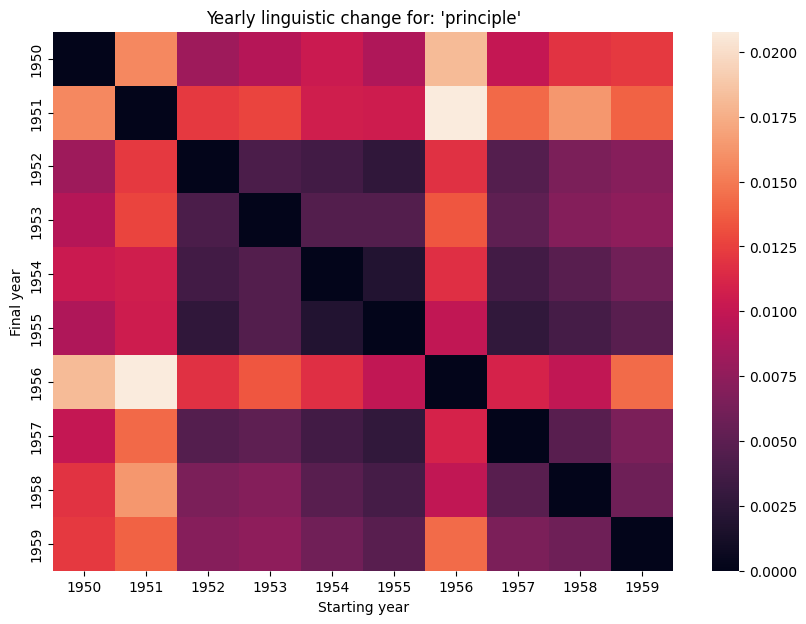

In [55]:
targetWord = wordDivergences[-200][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

special


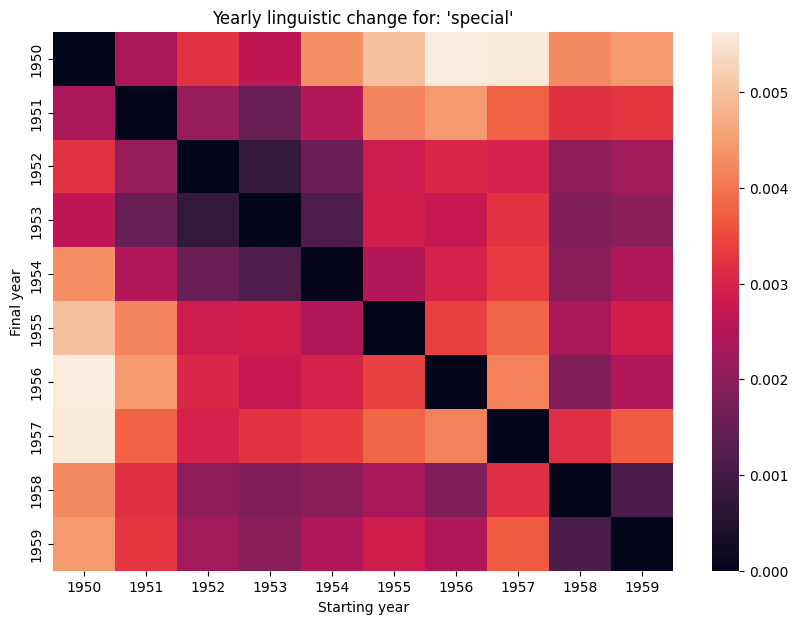

In [56]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [57]:
corpora_address = "COHA"

In [58]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

FileNotFoundError: [Errno 2] No such file or directory: 'COHA/'

Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [ ]:
coha_df = pd.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)

    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4

    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space?

For this exercise, I will look at the temporal changes in word embeddings in psychology paper abstracts from 2003 to 2023:

In [59]:
psychology_corpus.head()

,Year,FieldOfStudy,Title,Author,Abstract,tokenized_sents,normalized_sents
0,2003,Psychology,Maps of Bounded Rationality: Psychology for Be...,D. Kahneman,The work cited by the Nobel committee was done...,"[[The, work, cited, by, the, Nobel, committee,...","[[work, cited, nobel, committee, jointly, amos..."
1,2003,Psychology,DSM-Oriented and Empirically Based Approaches ...,"T. Achenbach, L. Dumenci, L. Rescorla","Department of Psychology, Bryn Mawr College Se...","[[Department, of, Psychology, Bryn, Mawr, Coll...","[[department, psychology, bryn, mawr, college,..."
2,2003,Psychology,Does father absence place daughters at special...,"B. Ellis, J. Bates, K. Dodge, D. Fergusson, L....",The impact of father absence on early sexual a...,"[[The, impact, of, father, absence, on, early,...","[[impact, father, absence, early, sexual, acti..."
3,2003,Psychology,The Psychology of the Body,"E. Greene, Barbara Goodrich-Dunn",Section I: The Body Organizes Experience1. The...,"[[Section, I, The, Body, Organizes, Experience...","[[section, body, organizes, experience1], [psy..."
4,2003,Psychology,Validation of the Female Sexual Function Index...,C. Meston,"Department of Psychology, University of Texas ...","[[Department, of, Psychology, University, of, ...","[[department, psychology, university, texas, a..."


Generate the models to create two collections of embeddings, one the original and one the aligned:

In [60]:
rawEmbeddings, comparedEmbeddings = compareModels(psychology_corpus, 'Year')

In [61]:
rawEmbeddings.keys()

dict_keys([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

Compare them across all permutions (using 1 - cosine similarity to give a more intitive range of 0-2 with low values meaning little change and high meaning lots of change):

Look at a couple words:

memory


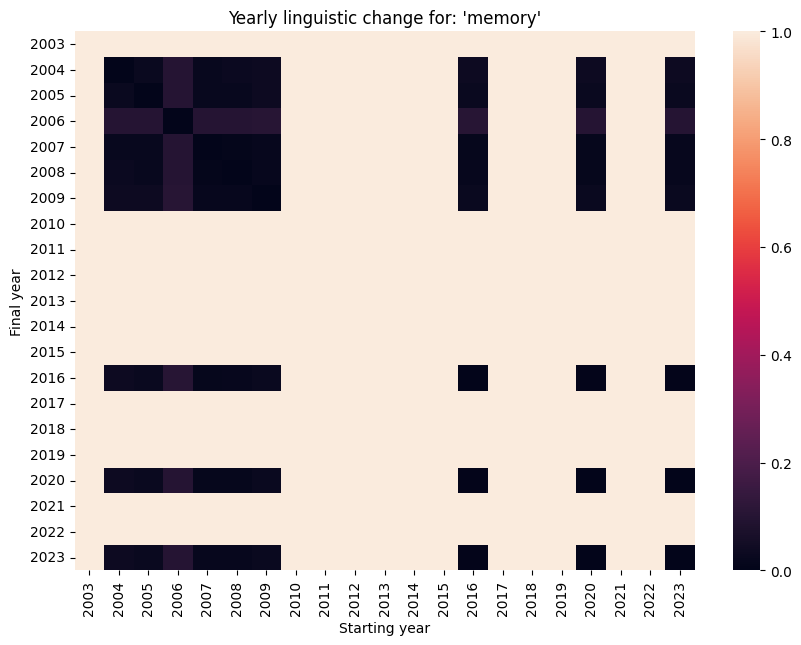

In [67]:
targetWord = 'memory'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [68]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0].wv[word], axis = 0), np.expand_dims(embed.wv[word], axis = 0))[0,0])
        except:
            pass
    return np.mean(dists)

# Update the function to compare original words starting from 2003
def findMostDivergent(embeddingsDict):
    original_words = comparedEmbeddings[2003][0].wv.index_to_key
    for embeds in embeddingsDict.values():
        for embed in embeds:
            original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)


In [69]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 924 words to compare


The most divergent words are:

In [70]:
wordDivergences[:20]

[('benefits', 0.9999999999999939),
 ('considering', 0.999999999999966),
 ('practice', 0.9999999999989159),
 ('participation', 0.9999999999982206),
 ('variety', 0.9999999999965962),
 ('mean', 0.9999999999963145),
 ('past', 0.9999999999957061),
 ('similar', 0.9999999999940152),
 ('disciplinary', 0.9999999999938306),
 ('understand', 0.9999999999918132),
 ('internal', 0.9999999999903283),
 ('leading', 0.9999999999868462),
 ('promote', 0.9999999999853936),
 ('skills', 0.9999999999823518),
 ('articles', 0.9999999999804954),
 ('medicine', 0.999999999978229),
 ('abstract', 0.9999999999781305),
 ('programs', 0.9999999999779906),
 ('open', 0.9999999999709333),
 ('common', 0.9999999999708498)]

And the least:

In [71]:
wordDivergences[-20:]

[('men', 0.3956589374157791),
 ('begin', 0.3951397774525988),
 ('relative', 0.39487150112417035),
 ('depth', 0.3947815094497319),
 ('feel', 0.3946925638800122),
 ('neural', 0.39466930070518547),
 ('building', 0.39455012253224125),
 ('enhance', 0.3941552291498037),
 ('examines', 0.3575552966441255),
 ('meta', 0.3560146416500487),
 ('explore', 0.354890323798905),
 ('feelings', 0.35165326512688944),
 ('doctoral', 0.350061982676348),
 ('variables', 0.34895261651089443),
 ('personality', 0.31277469258580803),
 ('everyday', 0.30843137328698395),
 ('relation', 0.3044459935443465),
 ('produced', 0.270891673833139),
 ('hypothesis', 0.2622567062883738),
 ('provide', 0.257868945923523)]

creativity


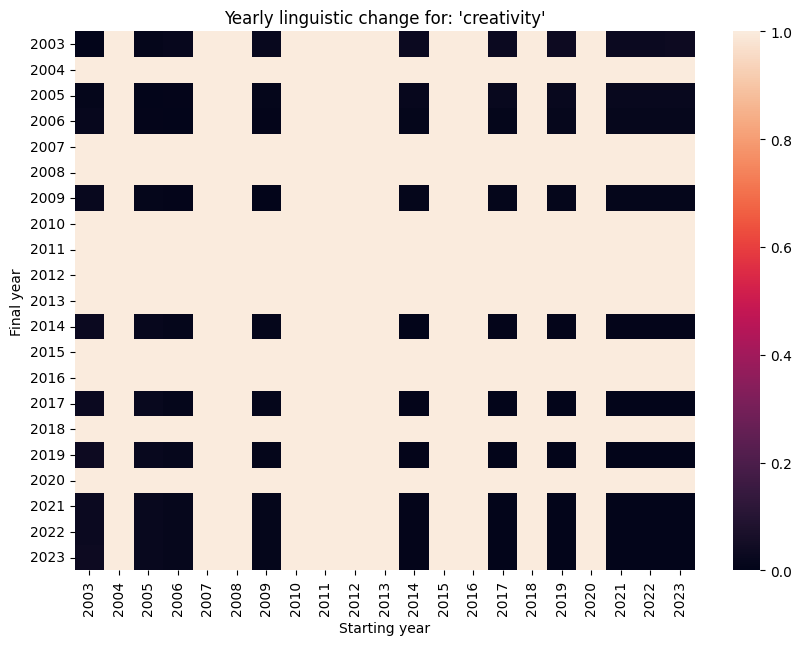

In [72]:
targetWord = wordDivergences[-200][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

provide


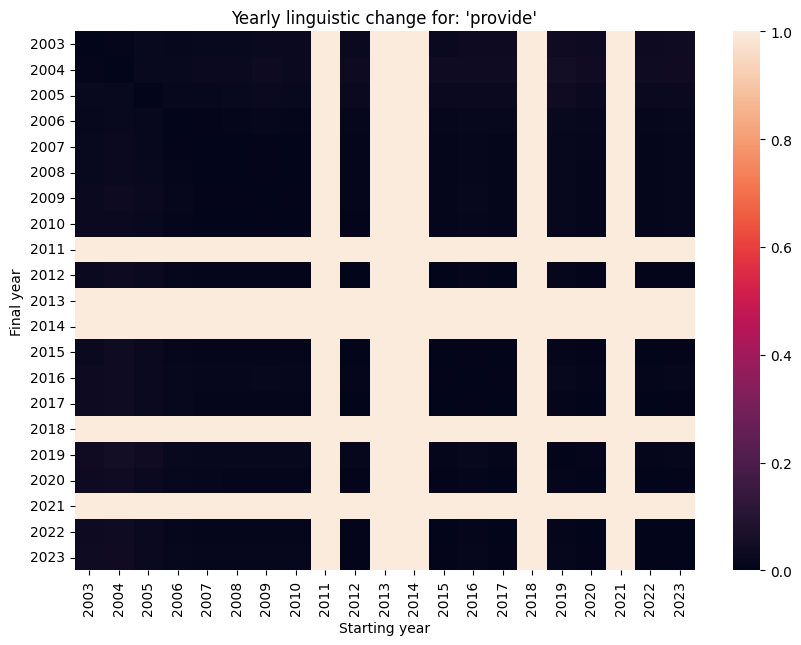

In [73]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

**General Discussion**:

The analysis of most divergent and least divergent words shed light on the temporal changes in psychology study. For instance, that benefits, practice, and participation may suggest an increasing focus on practical and applied research. Also, words such as variety and disciplinary may indicate interdisciplinary research or a whole variety of methods and approaches being utilized in the field of psychology.

On the other extreme, that feel and feelings may indicate the consistent topics of interest in emotion study. In addition, words such as explore and variables: might be attributed to the prevalence of these word usage in psychology research (e.g., to study relationships between variables).

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
from gensim.test.utils import datapath
import re
import string, re
import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics.




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)

##create the saving folder if you need!!

def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'):
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms.
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()

        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document).



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
##make sure to create a saving path first

dictionary, alpha = do_aksvd(w2v, 150, 5, save=True)

In [ ]:
topic_diversity(w2v, dictionary, top_n=25)

0.8034666666666667

In [ ]:
reconst_qual(w2v, dictionary, alpha)


(16714.18224838863, 0.11030937541961874, 0.868297053345052)

In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


Discourse_Atom 0
['ends', 'desperately', 'daunting', 'faces', 'obviously', 'facing', 'desperate', 'challenge', 'needs', 'face', 'struggling', 'faced', 'heal', 'tackle', 'urgent', 'struggle', 'challenges', 'dire', 'worse', 'unmet', 'crisis', 'safer', 'confront', 'solve', 'focus']


Discourse_Atom 1
['forget', 'hopes', 'feel', 'talk', 'stood', 'forever', 'minds', 'moment', 'mind', 'afraid', 'happened', 'remember', 'alive', 'tall', 'lot', 'got', 'pledge', 'knew', 'patriotism', 'forgotten', 'truth', 'things', 'reminded', 'fathers', 'hearts']


Discourse_Atom 2
['house', 'supremacist', 'collar', 'party', 'democrats', 'republican', 'congress', 'independents', 'houses', 'summaries', 'democratic', 'partisan', 'ryan', 'opponent', 'disappear', 'compromise', 'slogan', 'culmination', 'opposition', 'black', 'republicans', 'skip', 'cynical', 'mckeon', 'negotiators']


Discourse_Atom 3
['essential', 'tools', 'maintain', 'strengthen', 'effectively', 'necessary', 'adequate', 'enable', 'securing', 'tool

In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

[('funds', 0.7516657114028931),
 ('funding', 0.6887559294700623),
 ('resources', 0.6219789385795593),
 ('assistance', 0.6081899404525757),
 ('efforts', 0.575427770614624),
 ('reimbursements', 0.5240765810012817),
 ('effort', 0.5111767053604126),
 ('communities', 0.5077028274536133),
 ('desperately', 0.5070760250091553),
 ('responders', 0.5020491480827332),
 ('match', 0.49038416147232056),
 ('deliver', 0.4859146773815155),
 ('grants', 0.4784278869628906),
 ('declaration', 0.47553300857543945),
 ('commonsense', 0.47147828340530396),
 ('governments', 0.4701017439365387),
 ('support', 0.4608587920665741),
 ('programs', 0.4598115384578705),
 ('rebuild', 0.4564478099346161),
 ('flexibility', 0.4534948468208313),
 ('initiative', 0.4531988799571991),
 ('gear', 0.45291605591773987),
 ('firefighting', 0.45242419838905334),
 ('agencies', 0.45125699043273926),
 ('evacuees', 0.4423292577266693)]

In [ ]:
#useful relevant code:
w2v.wv.index_to_key[3452]

'balances'

In [ ]:
w2v.wv.most_similar('divorced', topn=15)

[('pregnant', 0.8717613816261292),
 ('married', 0.8586174845695496),
 ('disproportionately', 0.8537034392356873),
 ('color', 0.839481770992279),
 ('minorities', 0.8368760347366333),
 ('sore', 0.8331732153892517),
 ('couples', 0.8202372193336487),
 ('babies', 0.8103613257408142),
 ('ages', 0.7914664149284363),
 ('shouldered', 0.788785994052887),
 ('everyday', 0.7813878655433655),
 ('aged', 0.7813552021980286),
 ('caregivers', 0.7750584483146667),
 ('spouse', 0.770943820476532),
 ('bankrupt', 0.7709380984306335)]

In [ ]:
np.where(alpha[w2v.wv.key_to_index['divorced']] != 0) #get index where the loading of a word onto discourse atoms is not 0

(array([ 22,  37, 105, 110, 134]),)